In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal(os.path.join(data_path,'datasets/Brandeis99_reduced.graphml'),'graphml')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/Brandeis99_reduced.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [5]:
# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(n):
    pos[i] = [xx[i],yy[i]]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [6]:
g_v_prop = g_gtool.vertex_properties
#feature_list = [g_v_prop.secondMajor,g_v_prop.highSchool,g_v_prop.gender,g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 1000:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 1000:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_Brandeis', ref_nodes) 
            np.save('results/info_ref_nodes_Brandeis', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 2 Feature value  2007  gap  [0.90911795]  volume:  63073.0  size: 680 conductance:  0.4394114755917746
Reached
Number of feature 2 Feature value  2008  gap  [0.91702467]  volume:  63716.0  size: 722 conductance:  0.33595957059451315
Reached
Number of feature 2 Feature value  2009  gap  [0.88030531]  volume:  32534.0  size: 677 conductance:  0.14403393373086618


## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [7]:
ref_nodes = np.load('results/ref_nodes_Brandeis.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_Brandeis.npy') 

## Visualize the ground truth clusters

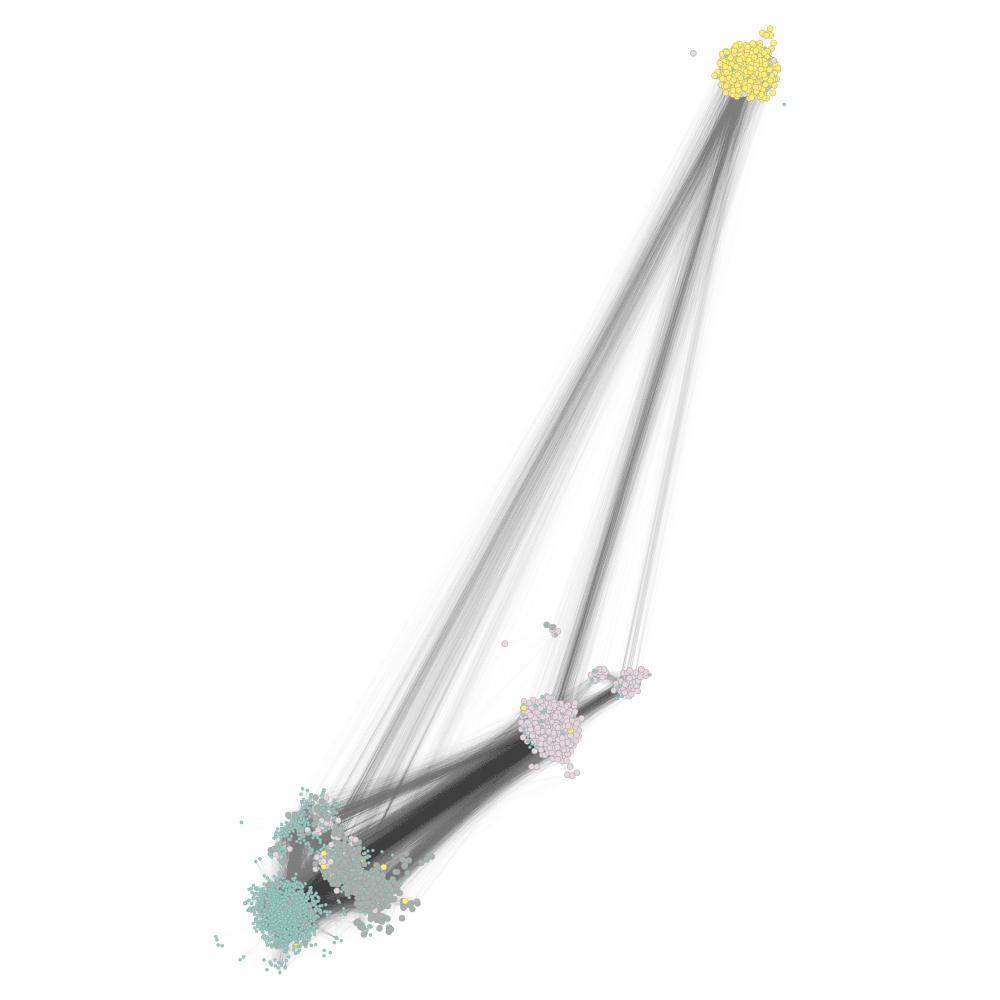

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x146b5bc18, at 0x1439b6908>

In [8]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
        
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("int",temp2)

c_map = plt.get_cmap('Dark2')

graph_draw(g_gtool, pos, output_size=(1000, 1000),
            vertex_size=node_size, 
            vertex_fill_color=node_colours,
            edge_pen_width=0.1,
            edge_color = [0.0, 0, 0, 0.05]
            )

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [9]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=2.0e-7,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_Brandeis', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_Brandeis', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_Brandeis', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_Brandeis', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_Brandeis', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_Brandeis', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_Brandeis', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_Brandeis', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_Brandeis', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_Brandeis', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_Brandeis', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_Brandeis', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_Brandeis', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_Brandeis', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_Brandeis', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_Brandeis', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_Brandeis', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_Brandeis', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_Brandeis', cuts_acl_ALL) 
    
    np.save('results/nodes_Brandeis', nodes)

340
outer: 0 number of node:  3673  completed:  0.0  degree:  134.0
conductance:  0.23365636055991387 f1score:  0.6422875586536115 precision:  0.5611293437437058 recall:  0.7508918237597704
outer: 0 number of node:  1839  completed:  0.0029411764705882353  degree:  126.0
conductance:  0.20615922538999462 f1score:  0.4789536906429279 precision:  0.3492832010235831 recall:  0.7617522553231969
outer: 0 number of node:  2756  completed:  0.0058823529411764705  degree:  108.0
conductance:  0.27017371812832724 f1score:  0.4659418881129339 precision:  0.33980660171586446 recall:  0.7409985255180506
outer: 0 number of node:  2266  completed:  0.008823529411764706  degree:  52.0
conductance:  0.25978234912837306 f1score:  0.5296680291097597 precision:  0.38627523682813875 recall:  0.8423731232064433
outer: 0 number of node:  2009  completed:  0.011764705882352941  degree:  11.0
conductance:  0.2383213002340685 f1score:  0.6755733067066066 precision:  0.5822471085000918 recall:  0.80452808650294

outer: 0 number of node:  1869  completed:  0.12058823529411765  degree:  86.0
conductance:  0.20255324959038776 f1score:  0.5542149452565662 precision:  0.40422112160815715 recall:  0.8812011478762704
outer: 0 number of node:  905  completed:  0.12352941176470589  degree:  8.0
conductance:  0.15022456735450235 f1score:  0.41478458409277014 precision:  0.2619451754294508 recall:  0.9958302284654289
outer: 0 number of node:  41  completed:  0.1264705882352941  degree:  62.0
conductance:  0.21963539811546806 f1score:  0.5588795633592504 precision:  0.4704046806435885 recall:  0.6883452507412047
outer: 0 number of node:  2641  completed:  0.12941176470588237  degree:  205.0
conductance:  0.1518083095749111 f1score:  0.530514606943157 precision:  0.3868590325980303 recall:  0.8438793144451667
outer: 0 number of node:  2783  completed:  0.1323529411764706  degree:  65.0
conductance:  0.1762629893471015 f1score:  0.6035392488530212 precision:  0.5181185777939438 recall:  0.7226864109840978
o

outer: 0 number of node:  3814  completed:  0.24411764705882352  degree:  136.0
conductance:  0.3274438032586469 f1score:  0.6237660631354116 precision:  0.5600837791460583 recall:  0.7037876745992738
outer: 0 number of node:  1007  completed:  0.24705882352941178  degree:  96.0
conductance:  0.24684436801375753 f1score:  0.47914785341881405 precision:  0.3495799420509311 recall:  0.7613241799185071
outer: 0 number of node:  1365  completed:  0.25  degree:  44.0
conductance:  0.20339668418924384 f1score:  0.4504435363301107 precision:  0.3284685326375312 recall:  0.716518954227641
outer: 0 number of node:  3277  completed:  0.2529411764705882  degree:  85.0
conductance:  0.2618289910823571 f1score:  0.5730147633342929 precision:  0.504678313151191 recall:  0.6627558543275253
outer: 0 number of node:  2645  completed:  0.25588235294117645  degree:  50.0
conductance:  0.33503955328059565 f1score:  0.49904250862739624 precision:  0.3640206328073277 recall:  0.7932871434686791
outer: 0 num

outer: 0 number of node:  2703  completed:  0.36764705882352944  degree:  138.0
conductance:  0.32808784496236776 f1score:  0.591005816427862 precision:  0.5148900607373228 recall:  0.6935297195313367
outer: 0 number of node:  2274  completed:  0.37058823529411766  degree:  85.0
conductance:  0.33239770504439387 f1score:  0.6051272734895226 precision:  0.5409774623956823 recall:  0.6865378212547366
outer: 0 number of node:  3039  completed:  0.3735294117647059  degree:  96.0
conductance:  0.2059628840888348 f1score:  0.6339868833135738 precision:  0.5583236770954036 recall:  0.7333724414567248
outer: 0 number of node:  2257  completed:  0.3764705882352941  degree:  85.0
conductance:  0.25968425668761874 f1score:  0.4058529617105886 precision:  0.254589414879876 recall:  1.0
outer: 0 number of node:  2568  completed:  0.37941176470588234  degree:  52.0
conductance:  0.23880597014925373 f1score:  0.4775620142802448 precision:  0.4143046944198406 recall:  0.5636167615302903
outer: 0 numbe

outer: 0 number of node:  1940  completed:  0.49117647058823527  degree:  28.0
conductance:  0.34841089134119463 f1score:  0.5343025399324411 precision:  0.3895714213061515 recall:  0.8501418990693324
outer: 0 number of node:  1452  completed:  0.49411764705882355  degree:  45.0
conductance:  0.35813419217878717 f1score:  0.5576556908016069 precision:  0.4066841634617482 recall:  0.8868929652941829
outer: 0 number of node:  72  completed:  0.4970588235294118  degree:  16.0
conductance:  0.325055071283688 f1score:  0.5290646090658053 precision:  0.385833412093145 recall:  0.8414218445293549
outer: 0 number of node:  2620  completed:  0.5  degree:  267.0
conductance:  0.16234768614313397 f1score:  0.4921895570918577 precision:  0.40095177285152744 recall:  0.637182312558464
outer: 0 number of node:  889  completed:  0.5029411764705882  degree:  41.0
conductance:  0.2825577373861584 f1score:  0.49769249937702464 precision:  0.3629313039243478 recall:  0.7916382604283925
outer: 0 number of

outer: 0 number of node:  3004  completed:  0.6147058823529412  degree:  38.0
conductance:  0.20580791261489276 f1score:  0.4717101922779752 precision:  0.4401296275952983 recall:  0.5081730693006516
outer: 0 number of node:  3652  completed:  0.6176470588235294  degree:  159.0
conductance:  0.16163208677555654 f1score:  0.623300187782777 precision:  0.5172190209263655 recall:  0.7841231588793938
outer: 0 number of node:  3572  completed:  0.6205882352941177  degree:  177.0
conductance:  0.28570181945111045 f1score:  0.49730917365801985 precision:  0.42319763171366886 recall:  0.6028887162494253
outer: 0 number of node:  2725  completed:  0.6235294117647059  degree:  73.0
conductance:  0.38723398067429127 f1score:  0.43716233727397785 precision:  0.31879538565540705 recall:  0.6953371490178047
outer: 0 number of node:  693  completed:  0.6264705882352941  degree:  54.0
conductance:  0.26985895873236987 f1score:  0.6394196550780182 precision:  0.5625248353342084 recall:  0.7406655779810

outer: 0 number of node:  1618  completed:  0.7382352941176471  degree:  94.0
conductance:  0.2940625835784969 f1score:  0.4073649961559547 precision:  0.25607677123607236 recall:  0.995497280928448
outer: 0 number of node:  1572  completed:  0.7411764705882353  degree:  70.0
conductance:  0.19256565117287863 f1score:  0.5196488481881583 precision:  0.37898839475291585 recall:  0.8263440774975029
outer: 0 number of node:  3562  completed:  0.7441176470588236  degree:  129.0
conductance:  0.2048554373561877 f1score:  0.6545423362093986 precision:  0.5604532155485015 recall:  0.7865964834398237
outer: 0 number of node:  297  completed:  0.7470588235294118  degree:  67.0
conductance:  0.23102631945411503 f1score:  0.5416885984400528 precision:  0.476133823635446 recall:  0.62817687441536
outer: 0 number of node:  1887  completed:  0.75  degree:  113.0
conductance:  0.22141658274588788 f1score:  0.6042965341965177 precision:  0.5025394054741801 recall:  0.7577251755901891
outer: 0 number o

outer: 0 number of node:  1779  completed:  0.861764705882353  degree:  6.0
conductance:  0.16367100666878373 f1score:  0.5861949505447501 precision:  0.5289914250714577 recall:  0.6572701472896485
outer: 0 number of node:  67  completed:  0.8647058823529412  degree:  41.0
conductance:  0.23559130492587915 f1score:  0.5735539290814076 precision:  0.5426675720793368 recall:  0.6081683129072661
outer: 0 number of node:  3119  completed:  0.8676470588235294  degree:  61.0
conductance:  0.32641499829102094 f1score:  0.4901132195822038 precision:  0.3573863182145219 recall:  0.7796680037416961
outer: 0 number of node:  3132  completed:  0.8705882352941177  degree:  154.0
conductance:  0.3263069078636321 f1score:  0.5942642219087918 precision:  0.5330580593181933 recall:  0.6713490717105576
outer: 0 number of node:  1546  completed:  0.8735294117647059  degree:  229.0
conductance:  0.3320728647783878 f1score:  0.45280216877796936 precision:  0.33018394831132397 recall:  0.7202923596467585
ou

outer: 0 number of node:  2445  completed:  0.9852941176470589  degree:  70.0
conductance:  0.20514529458810984 f1score:  0.547205724080201 precision:  0.3989958073868467 recall:  0.870594390626734
outer: 0 number of node:  3716  completed:  0.9882352941176471  degree:  65.0
conductance:  0.313911620294599 f1score:  0.503104042729166 precision:  0.36683062928222154 recall:  0.800469297480697
outer: 0 number of node:  3179  completed:  0.9911764705882353  degree:  65.0
conductance:  0.176390509529366 f1score:  0.5439437180593351 precision:  0.4678014087240431 recall:  0.6496916271621772
outer: 0 number of node:  2000  completed:  0.9941176470588236  degree:  4.0
conductance:  0.18861323155216286 f1score:  0.6965094371938478 precision:  0.6132437388409014 recall:  0.8059391498739555
outer: 0 number of node:  1449  completed:  0.9970588235294118  degree:  77.0
conductance:  0.18689813298395022 f1score:  0.4936739768485989 precision:  0.35997703588506313 recall:  0.7853598211596087
361
out

outer: 1 number of node:  3212  completed:  0.0997229916897507  degree:  107.0
conductance:  0.2970075991709995 f1score:  0.5670188615511478 precision:  0.41479581083339995 recall:  0.8957404733504928
outer: 1 number of node:  3506  completed:  0.10249307479224377  degree:  206.0
conductance:  0.2815300896286812 f1score:  0.6302292320527592 precision:  0.46097405050416995 recall:  0.9958880030133719
outer: 1 number of node:  665  completed:  0.10526315789473684  degree:  33.0
conductance:  0.28681381036213643 f1score:  0.5907768099244148 precision:  0.4321229821425977 recall:  0.9335174838345157
outer: 1 number of node:  2053  completed:  0.10803324099722991  degree:  64.0
conductance:  0.32080328059562585 f1score:  0.600321984377795 precision:  0.4392159143787808 recall:  0.9480821143825726
outer: 1 number of node:  3807  completed:  0.11080332409972299  degree:  71.0
conductance:  0.32814488853329454 f1score:  0.5928806639548224 precision:  0.43368477652717935 recall:  0.936734886056

outer: 1 number of node:  2934  completed:  0.21329639889196675  degree:  28.0
conductance:  0.3013703583179665 f1score:  0.49182444916853757 precision:  0.359769212882223 recall:  0.7770418733128257
outer: 1 number of node:  3483  completed:  0.21606648199445982  degree:  66.0
conductance:  0.3276931918205824 f1score:  0.6082232055503409 precision:  0.44488924085119985 recall:  0.9610615857869295
outer: 1 number of node:  2673  completed:  0.2188365650969529  degree:  128.0
conductance:  0.2923513159808056 f1score:  0.580414993838693 precision:  0.42464737530900104 recall:  0.9166614351183376
outer: 1 number of node:  1832  completed:  0.22160664819944598  degree:  54.0
conductance:  0.298504315453468 f1score:  0.6279738691969498 precision:  0.4594015074975105 recall:  0.9919643417665892
outer: 1 number of node:  1472  completed:  0.22437673130193905  degree:  181.0
conductance:  0.2896495067212412 f1score:  0.6243895168302075 precision:  0.456800354756868 recall:  0.9862044070563124


outer: 1 number of node:  1471  completed:  0.3268698060941828  degree:  128.0
conductance:  0.28609672350579063 f1score:  0.6298339795208271 precision:  0.46088430425420474 recall:  0.994334233159646
outer: 1 number of node:  2488  completed:  0.3296398891966759  degree:  107.0
conductance:  0.274591654182363 f1score:  0.603612195630793 precision:  0.44155608203369134 recall:  0.9535909347730555
outer: 1 number of node:  1276  completed:  0.33240997229916897  degree:  111.0
conductance:  0.3147897668601015 f1score:  0.6049495602047409 precision:  0.4426240237357651 recall:  0.9552859564316655
outer: 1 number of node:  1483  completed:  0.33518005540166207  degree:  71.0
conductance:  0.30112461031961074 f1score:  0.6178659555838574 precision:  0.4523060338548495 recall:  0.974606064410823
outer: 1 number of node:  2205  completed:  0.3379501385041551  degree:  94.0
conductance:  0.3091591395034254 f1score:  0.6294195368613464 precision:  0.4604305044838161 recall:  0.9943813170946073


outer: 1 number of node:  2611  completed:  0.4404432132963989  degree:  113.0
conductance:  0.28209900327878384 f1score:  0.5991245460010832 precision:  0.4383246941134561 recall:  0.9462615355640656
outer: 1 number of node:  2337  completed:  0.44321329639889195  degree:  106.0
conductance:  0.32632391381909 f1score:  0.5546219321537583 precision:  0.4055629350579593 recall:  0.8769225940109234
outer: 1 number of node:  1053  completed:  0.44598337950138506  degree:  191.0
conductance:  0.28309898067499384 f1score:  0.6307326913712746 precision:  0.4614590452370912 recall:  0.996139117333166
outer: 1 number of node:  2242  completed:  0.4487534626038781  degree:  109.0
conductance:  0.2809911947124648 f1score:  0.6257445614104813 precision:  0.4577727381757125 recall:  0.988433046644485
outer: 1 number of node:  243  completed:  0.4515235457063712  degree:  39.0
conductance:  0.3010594638647146 f1score:  0.6274603269181116 precision:  0.4589192330040674 recall:  0.9916504488668466
ou

outer: 1 number of node:  2208  completed:  0.556786703601108  degree:  73.0
conductance:  0.31437711294485443 f1score:  0.6299244784526806 precision:  0.4615637487307234 recall:  0.9916347542218595
outer: 1 number of node:  2416  completed:  0.5595567867036011  degree:  119.0
conductance:  0.3011767786230672 f1score:  0.6274837234729885 precision:  0.45913276215689414 recall:  0.9907715487475673
outer: 1 number of node:  1222  completed:  0.5623268698060941  degree:  22.0
conductance:  0.3094664872531549 f1score:  0.6185655140879021 precision:  0.4526166490889915 recall:  0.97664636825915
outer: 1 number of node:  1813  completed:  0.5650969529085873  degree:  216.0
conductance:  0.27390918223244576 f1score:  0.6295954331099528 precision:  0.4604237152772736 recall:  0.9952916065038608
outer: 1 number of node:  3362  completed:  0.5678670360110804  degree:  48.0
conductance:  0.28697006301756633 f1score:  0.6269351843576528 precision:  0.45852882646020654 recall:  0.9908500219725029
o

outer: 1 number of node:  201  completed:  0.6731301939058172  degree:  80.0
conductance:  0.31950756611717485 f1score:  0.621918202908054 precision:  0.4549630415664271 recall:  0.9824376922594011
outer: 1 number of node:  3779  completed:  0.6759002770083102  degree:  104.0
conductance:  0.3009057509730457 f1score:  0.6197712393933519 precision:  0.4535302462624132 recall:  0.9784041684977086
outer: 1 number of node:  3109  completed:  0.6786703601108033  degree:  97.0
conductance:  0.2779257448078127 f1score:  0.6172402477950023 precision:  0.4517166601173063 recall:  0.9742293929311319
outer: 1 number of node:  1348  completed:  0.6814404432132964  degree:  41.0
conductance:  0.3199549205656742 f1score:  0.6293732701949307 precision:  0.46047187988512017 recall:  0.9939575616799547
outer: 1 number of node:  2339  completed:  0.6842105263157895  degree:  50.0
conductance:  0.31652950242824324 f1score:  0.5600469007730678 precision:  0.40972666472811864 recall:  0.8845815807646431
ou

outer: 1 number of node:  3364  completed:  0.7894736842105263  degree:  69.0
conductance:  0.29402013886364464 f1score:  0.5789873757321926 precision:  0.42358046858530274 recall:  0.9145112687551008
outer: 1 number of node:  3306  completed:  0.7922437673130194  degree:  56.0
conductance:  0.3212126503262981 f1score:  0.6129136488589083 precision:  0.44851619849982904 recall:  0.9675591688116015
outer: 1 number of node:  384  completed:  0.7950138504155124  degree:  43.0
conductance:  0.30816969450042564 f1score:  0.6288631607204108 precision:  0.460191928525177 recall:  0.9927176847259715
outer: 1 number of node:  3681  completed:  0.7977839335180056  degree:  15.0
conductance:  0.20189560716566396 f1score:  0.4116982829188116 precision:  0.2593059036905708 recall:  0.9985247033712098
outer: 1 number of node:  1028  completed:  0.8005540166204986  degree:  149.0
conductance:  0.29591480446927376 f1score:  0.616577529474919 precision:  0.451175512104283 recall:  0.9734446606817754
ou

outer: 1 number of node:  2020  completed:  0.9058171745152355  degree:  97.0
conductance:  0.30455391415610095 f1score:  0.5543057018502694 precision:  0.40553390717692217 recall:  0.8754786866721075
outer: 1 number of node:  3015  completed:  0.9085872576177285  degree:  24.0
conductance:  0.29033852954862727 f1score:  0.6252062091308409 precision:  0.45742205677059095 recall:  0.9873815054303472
outer: 1 number of node:  779  completed:  0.9113573407202216  degree:  45.0
conductance:  0.2892974278047255 f1score:  0.6285998260653497 precision:  0.45993353162338463 recall:  0.9926078222110616
outer: 1 number of node:  1167  completed:  0.9141274238227147  degree:  10.0
conductance:  0.25321719911009 f1score:  0.5631577378290552 precision:  0.41201960128542553 recall:  0.8894155314206793
outer: 1 number of node:  1862  completed:  0.9168975069252078  degree:  86.0
conductance:  0.2903662020981919 f1score:  0.6302061338354606 precision:  0.46105364165715573 recall:  0.9954014690187708
o

outer: 2 number of node:  3124  completed:  0.023668639053254437  degree:  156.0
conductance:  0.1395178516936222 f1score:  0.9833394585324022 precision:  0.9797985962770827 recall:  0.9869060060244668
outer: 2 number of node:  896  completed:  0.026627218934911243  degree:  79.0
conductance:  0.14670722433460076 f1score:  0.973444021464936 precision:  0.9683954372623574 recall:  0.9785455216081638
outer: 2 number of node:  732  completed:  0.029585798816568046  degree:  30.0
conductance:  0.13898840245309368 f1score:  0.9817021016617792 precision:  0.9756815835812739 recall:  0.9877973812012049
outer: 2 number of node:  3129  completed:  0.03254437869822485  degree:  68.0
conductance:  0.1349278119055786 f1score:  0.9817502602731337 precision:  0.9780367274723933 recall:  0.9854921005717096
outer: 2 number of node:  1515  completed:  0.03550295857988166  degree:  69.0
conductance:  0.1458514759316537 f1score:  0.9754082175134806 precision:  0.9641752499924927 recall:  0.98690600602446

outer: 2 number of node:  143  completed:  0.14792899408284024  degree:  1.0
conductance:  0.132266731802638 f1score:  0.9876543209876544 precision:  0.9843673668783586 recall:  0.9909632999323784
outer: 2 number of node:  2100  completed:  0.15088757396449703  degree:  38.0
conductance:  0.15406263098018083 f1score:  0.9695158942004368 precision:  0.9569187473803964 recall:  0.9824491301407758
outer: 2 number of node:  3314  completed:  0.15384615384615385  degree:  1.0
conductance:  0.14022230365213142 f1score:  0.976287491192059 precision:  0.973097593746183 recall:  0.9794983709350218
outer: 2 number of node:  3788  completed:  0.15680473372781065  degree:  167.0
conductance:  0.1394740985671548 f1score:  0.9765721331689273 precision:  0.9673975329493018 recall:  0.9859224196225487
outer: 2 number of node:  2046  completed:  0.15976331360946747  degree:  11.0
conductance:  0.1544720365385197 f1score:  0.9708361917829104 precision:  0.9630985148664589 recall:  0.9786992069834635
out

outer: 2 number of node:  1048  completed:  0.27218934911242604  degree:  74.0
conductance:  0.15676693942426562 f1score:  0.9668705402650357 precision:  0.9436706267922982 recall:  0.9912399336079178
outer: 2 number of node:  880  completed:  0.27514792899408286  degree:  79.0
conductance:  0.14795841946017196 f1score:  0.9755897747098535 precision:  0.9632126059734579 recall:  0.9882891744021639
outer: 2 number of node:  2859  completed:  0.2781065088757396  degree:  42.0
conductance:  0.152985737113097 f1score:  0.9699372813894584 precision:  0.9518553589394567 recall:  0.988719493453003
outer: 2 number of node:  1613  completed:  0.28106508875739644  degree:  30.0
conductance:  0.15548825747454054 f1score:  0.9696896473608698 precision:  0.9531783498114664 recall:  0.9867830577242269
outer: 2 number of node:  3870  completed:  0.28402366863905326  degree:  12.0
conductance:  0.13371296324492218 f1score:  0.9847490554204336 precision:  0.9801760102317366 recall:  0.9893649720292617


outer: 2 number of node:  3670  completed:  0.39644970414201186  degree:  16.0
conductance:  0.1863947980110042 f1score:  0.9330887990258715 precision:  0.913143260658487 recall:  0.953925124485154
outer: 2 number of node:  3780  completed:  0.3994082840236686  degree:  13.0
conductance:  0.16763742264288314 f1score:  0.9572200677883294 precision:  0.9509768232010678 recall:  0.9635458289789144
outer: 2 number of node:  3798  completed:  0.40236686390532544  degree:  40.0
conductance:  0.13289880351295938 f1score:  0.9858770490546364 precision:  0.9836898313901894 recall:  0.9880740148767443
outer: 2 number of node:  2587  completed:  0.40532544378698226  degree:  13.0
conductance:  0.14658584858980703 f1score:  0.9696007399414213 precision:  0.9725692726373083 recall:  0.966650273559968
outer: 2 number of node:  3318  completed:  0.40828402366863903  degree:  50.0
conductance:  0.1775996322156136 f1score:  0.9544232739801298 precision:  0.9233112088038388 recall:  0.9877051699760251
o

outer: 2 number of node:  3349  completed:  0.5207100591715976  degree:  7.0
conductance:  0.22819442124603306 f1score:  0.4273086672708407 precision:  0.2717053616168365 recall:  1.0
outer: 2 number of node:  950  completed:  0.5236686390532544  degree:  46.0
conductance:  0.14426782273603084 f1score:  0.9784638783269962 precision:  0.9684188342967245 recall:  0.988719493453003
outer: 2 number of node:  2631  completed:  0.5266272189349113  degree:  40.0
conductance:  0.1453956057149718 f1score:  0.9746393318147304 precision:  0.9632008644495137 recall:  0.9863527386733878
outer: 2 number of node:  1214  completed:  0.5295857988165681  degree:  57.0
conductance:  0.1644771413557541 f1score:  0.9596334670898965 precision:  0.9355403748467332 recall:  0.9850003073707506
outer: 2 number of node:  58  completed:  0.5325443786982249  degree:  32.0
conductance:  0.1322660626281796 f1score:  0.9871018204683835 precision:  0.9850622914689767 recall:  0.9891498125038422
outer: 2 number of node

outer: 2 number of node:  1441  completed:  0.6449704142011834  degree:  40.0
conductance:  0.13953629154307162 f1score:  0.9809674861221253 precision:  0.9734850777892124 recall:  0.9885658080777033
outer: 2 number of node:  1884  completed:  0.6479289940828402  degree:  40.0
conductance:  0.15994206496999794 f1score:  0.9691554283131169 precision:  0.9505778723655819 recall:  0.9884735968525236
outer: 2 number of node:  1527  completed:  0.650887573964497  degree:  24.0
conductance:  0.15381212210588407 f1score:  0.9657580637878354 precision:  0.9462321191564665 recall:  0.9861068420729083
outer: 2 number of node:  1906  completed:  0.6538461538461539  degree:  37.0
conductance:  0.14955854811379649 f1score:  0.971453614011757 precision:  0.9554980825827165 recall:  0.9879510665765046
outer: 2 number of node:  3519  completed:  0.6568047337278107  degree:  27.0
conductance:  0.15742530102571725 f1score:  0.9639257053907418 precision:  0.9481492492938903 recall:  0.9802360607364603
ou

outer: 2 number of node:  3611  completed:  0.7692307692307693  degree:  26.0
conductance:  0.13917541550610632 f1score:  0.9803542673107891 precision:  0.9782987970983441 recall:  0.9824183930657159
outer: 2 number of node:  888  completed:  0.772189349112426  degree:  25.0
conductance:  0.14050190114068442 f1score:  0.980201501322448 precision:  0.9751178707224335 recall:  0.9853384151964099
outer: 2 number of node:  3705  completed:  0.7751479289940828  degree:  41.0
conductance:  0.1666227800696334 f1score:  0.9584338884475289 precision:  0.9353696714356768 recall:  0.9826642896661953
outer: 2 number of node:  3312  completed:  0.7781065088757396  degree:  18.0
conductance:  0.140779787330728 f1score:  0.9792655203454221 precision:  0.9722196976582145 recall:  0.9864142128235077
outer: 2 number of node:  1997  completed:  0.7810650887573964  degree:  21.0
conductance:  0.134415009013964 f1score:  0.9836196196809732 precision:  0.9807192837718092 recall:  0.9865371611237475
outer: 2

outer: 2 number of node:  843  completed:  0.893491124260355  degree:  87.0
conductance:  0.13539134662129315 f1score:  0.9843026366068015 precision:  0.97896080994801 recall:  0.989703079854921
outer: 2 number of node:  2178  completed:  0.8964497041420119  degree:  48.0
conductance:  0.1369742012122689 f1score:  0.9820546163849155 precision:  0.9776126222168073 recall:  0.9865371611237475
outer: 2 number of node:  1816  completed:  0.8994082840236687  degree:  46.0
conductance:  0.1451953856374947 f1score:  0.9769680721423349 precision:  0.9684121519598962 recall:  0.9856765230220692
outer: 2 number of node:  1479  completed:  0.9023668639053254  degree:  8.0
conductance:  0.15058722252966858 f1score:  0.9684906240393483 precision:  0.9686097276025334 recall:  0.9683715497633245
outer: 2 number of node:  3209  completed:  0.9053254437869822  degree:  97.0
conductance:  0.14247718068065043 f1score:  0.9847912221883572 precision:  0.9765761953696428 recall:  0.993145632261634
outer: 2 

## Improve the results found by the spectral algorithm using MQI

In [10]:
nodes = np.load('results/nodes_Brandeis.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Brandeis.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_mqi_Brandeis', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_mqi_Brandeis', external_cond_acl_flow)
    np.save('results/vol_acl_flow_mqi_Brandeis', vol_acl_flow) 
    np.save('results/gap_acl_flow_mqi_Brandeis', gap_acl_flow) 
    np.save('results/cuts_acl_flow_mqi_Brandeis', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_mqi_Brandeis', true_positives_acl_flow)
    np.save('results/recall_acl_flow_mqi_Brandeis', recall_acl_flow) 
    np.save('results/precision_acl_flow_mqi_Brandeis', precision_acl_flow) 
    np.save('results/f1score_acl_flow_mqi_Brandeis', f1score_acl_flow) 

340
outer: 0 number of node:  3673  completed:  0.0  degree:  134.0
conductance:  0.17897350526226688 f1score:  0.41657527911739445 precision:  0.26310255479477773 recall:  0.9997463256861098
outer: 0 number of node:  1839  completed:  0.0029411764705882353  degree:  126.0
conductance:  0.1396370466870664 f1score:  0.413324857294527 precision:  0.2605028479849319 recall:  0.9999207267769092
outer: 0 number of node:  2756  completed:  0.0058823529411764705  degree:  108.0
conductance:  0.15597253462767846 f1score:  0.4141619551040924 precision:  0.2612050389524283 recall:  0.9993816688598925
outer: 0 number of node:  2266  completed:  0.008823529411764706  degree:  52.0
conductance:  0.16429579120620738 f1score:  0.414739756112797 precision:  0.26162250501899753 recall:  1.0
outer: 0 number of node:  2009  completed:  0.011764705882352941  degree:  11.0
conductance:  0.16494117647058823 f1score:  0.4147070329836512 precision:  0.2615964629958359 recall:  1.0
outer: 0 number of node:  31

outer: 0 number of node:  905  completed:  0.12352941176470589  degree:  8.0
conductance:  0.1357273280584297 f1score:  0.4131455091526623 precision:  0.2603571546514316 recall:  0.9999682907107638
outer: 0 number of node:  41  completed:  0.1264705882352941  degree:  62.0
conductance:  0.16387271336980178 f1score:  0.4147097597138527 precision:  0.2615986329664131 recall:  1.0
outer: 0 number of node:  2641  completed:  0.12941176470588237  degree:  205.0
conductance:  0.13284653617230166 f1score:  0.4127989737783348 precision:  0.26007983044277855 recall:  1.0
outer: 0 number of node:  2783  completed:  0.1323529411764706  degree:  65.0
conductance:  0.1389507736442152 f1score:  0.41292802556529823 precision:  0.26019947099335233 recall:  0.9997463256861098
outer: 0 number of node:  3238  completed:  0.13529411764705881  degree:  209.0
conductance:  0.17454524719165193 f1score:  0.4159125325380147 precision:  0.26260029829107545 recall:  0.9993658142152744
outer: 0 number of node:  1

outer: 0 number of node:  1007  completed:  0.24705882352941178  degree:  96.0
conductance:  0.16029814689332117 f1score:  0.41450443402862236 precision:  0.26145584972943836 recall:  0.9996987617522554
outer: 0 number of node:  1365  completed:  0.25  degree:  44.0
conductance:  0.1415937244449829 f1score:  0.41326630926321584 precision:  0.2604681710596429 recall:  0.9997463256861098
outer: 0 number of node:  3277  completed:  0.2529411764705882  degree:  85.0
conductance:  0.15711271581825206 f1score:  0.4142186319902801 precision:  0.2612100705301565 recall:  0.9999682907107638
outer: 0 number of node:  2645  completed:  0.25588235294117645  degree:  50.0
conductance:  0.3306677151101978 f1score:  0.5052254947542906 precision:  0.37080777134040044 recall:  0.7925102658823903
outer: 0 number of node:  1783  completed:  0.25882352941176473  degree:  65.0
conductance:  0.3176165803108808 f1score:  0.5142173757272687 precision:  0.37714285714285717 recall:  0.8078258525835144
outer: 0 

outer: 0 number of node:  2274  completed:  0.37058823529411766  degree:  85.0
conductance:  0.325472930114548 f1score:  0.573103035346411 precision:  0.4214245737099362 recall:  0.8953593455202702
outer: 0 number of node:  3039  completed:  0.3735294117647059  degree:  96.0
conductance:  0.1435151515151515 f1score:  0.41323673492124346 precision:  0.26044575148280935 recall:  0.9997304710414916
outer: 0 number of node:  2257  completed:  0.3764705882352941  degree:  85.0
conductance:  0.14853927851490809 f1score:  0.4136693950364657 precision:  0.2607712375605178 recall:  1.0
outer: 0 number of node:  2568  completed:  0.37941176470588234  degree:  52.0
conductance:  0.15335482330468003 f1score:  0.41401878054464236 precision:  0.2610511415373918 recall:  0.9999682907107638
outer: 0 number of node:  1050  completed:  0.38235294117647056  degree:  144.0
conductance:  0.1361603039401924 f1score:  0.41285841927322836 precision:  0.260127026023838 recall:  1.0
outer: 0 number of node:  17

outer: 0 number of node:  1452  completed:  0.49411764705882355  degree:  45.0
conductance:  0.3499828786668189 f1score:  0.5743593435070545 precision:  0.4250123654072975 recall:  0.8855294658570229
outer: 0 number of node:  72  completed:  0.4970588235294118  degree:  16.0
conductance:  0.3057732073109863 f1score:  0.560588291229516 precision:  0.4203579436068483 recall:  0.841215734149319
outer: 0 number of node:  2620  completed:  0.5  degree:  267.0
conductance:  0.13323284215707387 f1score:  0.41266839835903607 precision:  0.2599783183086632 recall:  0.9999682907107638
outer: 0 number of node:  889  completed:  0.5029411764705882  degree:  41.0
conductance:  0.15084572322879672 f1score:  0.4136544736108606 precision:  0.26075937853994924 recall:  1.0
outer: 0 number of node:  1943  completed:  0.5058823529411764  degree:  66.0
conductance:  0.3261615618300139 f1score:  0.541748687664042 precision:  0.40030606292471915 recall:  0.8377594216225643
outer: 0 number of node:  3612  co

outer: 0 number of node:  3652  completed:  0.6176470588235294  degree:  159.0
conductance:  0.14353154788924194 f1score:  0.4133959939174663 precision:  0.2605561362124736 recall:  0.9999682907107638
outer: 0 number of node:  3572  completed:  0.6205882352941177  degree:  177.0
conductance:  0.28444759062082653 f1score:  0.49592203898050974 precision:  0.3620965211235742 recall:  0.7866599020182963
outer: 0 number of node:  2725  completed:  0.6235294117647059  degree:  73.0
conductance:  0.38164581922627594 f1score:  0.44352837507976206 precision:  0.32584512125248344 recall:  0.6942748878283893
outer: 0 number of node:  693  completed:  0.6264705882352941  degree:  54.0
conductance:  0.1600685417159064 f1score:  0.41449990635258094 precision:  0.2614316505015336 recall:  1.0
outer: 0 number of node:  3682  completed:  0.6294117647058823  degree:  53.0
conductance:  0.33403063583376913 f1score:  0.4306343264447977 precision:  0.31825037707390647 recall:  0.6657206728711176
outer: 0 n

outer: 0 number of node:  1572  completed:  0.7411764705882353  degree:  70.0
conductance:  0.13712151122179367 f1score:  0.413236190189154 precision:  0.2604291831316247 recall:  0.9999682907107638
outer: 0 number of node:  3562  completed:  0.7441176470588236  degree:  129.0
conductance:  0.14700065919578115 f1score:  0.41385532484490184 precision:  0.26091902669876804 recall:  1.0
outer: 0 number of node:  297  completed:  0.7470588235294118  degree:  67.0
conductance:  0.14411594907477743 f1score:  0.41321453139843417 precision:  0.2604119786785138 recall:  0.9999682907107638
outer: 0 number of node:  1887  completed:  0.75  degree:  113.0
conductance:  0.1507284609389052 f1score:  0.41382047942576505 precision:  0.2608934850051706 recall:  0.9999682907107638
outer: 0 number of node:  3730  completed:  0.7529411764705882  degree:  60.0
conductance:  0.15594541910331383 f1score:  0.41390233403324755 precision:  0.26105699481865285 recall:  0.9985255180505129
outer: 0 number of node:

outer: 0 number of node:  67  completed:  0.8647058823529412  degree:  41.0
conductance:  0.1607137572870121 f1score:  0.41442501018437 precision:  0.2613720655574664 recall:  1.0
outer: 0 number of node:  3119  completed:  0.8676470588235294  degree:  61.0
conductance:  0.3212813663171448 f1score:  0.4952827808889561 precision:  0.3632239875089724 recall:  0.7782252310814453
outer: 0 number of node:  3132  completed:  0.8705882352941177  degree:  154.0
conductance:  0.32055132627572264 f1score:  0.5671989270440569 precision:  0.41657993338884264 recall:  0.8884150111775244
outer: 0 number of node:  1546  completed:  0.8735294117647059  degree:  229.0
conductance:  0.32006874462932583 f1score:  0.47388831031541256 precision:  0.3536911178814155 recall:  0.7178348897309467
outer: 0 number of node:  3097  completed:  0.8764705882352941  degree:  198.0
conductance:  0.14694235361687977 f1score:  0.41345788266142247 precision:  0.26060315584624855 recall:  1.0
outer: 0 number of node:  158

outer: 0 number of node:  3716  completed:  0.9882352941176471  degree:  65.0
conductance:  0.13639048655370745 f1score:  0.002058981912635814 precision:  1.0 recall:  0.0010305519001791576
outer: 0 number of node:  3179  completed:  0.9911764705882353  degree:  65.0
conductance:  0.13972335628541832 f1score:  0.4130940958019904 precision:  0.26031632038169766 recall:  0.9999682907107638
outer: 0 number of node:  2000  completed:  0.9941176470588236  degree:  4.0
conductance:  0.15335777519449165 f1score:  0.41407993907403035 precision:  0.2610997727263319 recall:  0.9999682907107638
outer: 0 number of node:  1449  completed:  0.9970588235294118  degree:  77.0
conductance:  0.13682411814963993 f1score:  0.4130395633396528 precision:  0.26027086359434837 recall:  1.0
361
outer: 1 number of node:  271  completed:  0.0  degree:  244.0
conductance:  0.25385662259460035 f1score:  0.6474495884615582 precision:  0.48054772023995074 recall:  0.9919800364115764
outer: 1 number of node:  170  co

outer: 1 number of node:  665  completed:  0.10526315789473684  degree:  33.0
conductance:  0.2749961294318006 f1score:  0.6164150630391506 precision:  0.46022604118284566 recall:  0.933078033774876
outer: 1 number of node:  2053  completed:  0.10803324099722991  degree:  64.0
conductance:  0.309116656649569 f1score:  0.6523774807614419 precision:  0.4973036168583637 recall:  0.9479879465126498
outer: 1 number of node:  3807  completed:  0.11080332409972299  degree:  71.0
conductance:  0.3188423645320197 f1score:  0.9193322764151823 precision:  0.9105295566502463 recall:  0.9283068616987884
outer: 1 number of node:  1160  completed:  0.11357340720221606  degree:  35.0
conductance:  0.30642397021452633 f1score:  0.9296803652968038 precision:  0.9024289344601383 recall:  0.9586289158139243
outer: 1 number of node:  804  completed:  0.11634349030470914  degree:  94.0
conductance:  0.28849405358933944 f1score:  0.9418752715233772 precision:  0.9008883794239863 recall:  0.9867694142758491
o

outer: 1 number of node:  2673  completed:  0.2188365650969529  degree:  128.0
conductance:  0.2825399805965011 f1score:  0.6094252537487991 precision:  0.4566159672018277 recall:  0.9159551760939167
outer: 1 number of node:  1832  completed:  0.22160664819944598  degree:  54.0
conductance:  0.27799059053397435 f1score:  0.7006823460287017 precision:  0.5416356017173561 recall:  0.9919643417665892
outer: 1 number of node:  1472  completed:  0.22437673130193905  degree:  181.0
conductance:  0.2845253495004909 f1score:  0.6541589860551337 precision:  0.48947991833299564 recall:  0.9858277355766213
outer: 1 number of node:  385  completed:  0.22714681440443213  degree:  36.0
conductance:  0.26895527056615576 f1score:  0.660180797093885 precision:  0.4945573975602127 recall:  0.9925921275660744
outer: 1 number of node:  2903  completed:  0.2299168975069252  degree:  66.0
conductance:  0.26247581611030923 f1score:  0.6428276829167697 precision:  0.4786414028191506 recall:  0.978466947077657

outer: 1 number of node:  1276  completed:  0.33240997229916897  degree:  111.0
conductance:  0.3000675929402929 f1score:  0.9194495398761234 precision:  0.8997070972587308 recall:  0.9400778454391362
outer: 1 number of node:  1483  completed:  0.33518005540166207  degree:  71.0
conductance:  0.2916781818477395 f1score:  0.6647031733621788 precision:  0.5044787280737405 recall:  0.9740724464812606
outer: 1 number of node:  2205  completed:  0.3379501385041551  degree:  94.0
conductance:  0.2866560325235386 f1score:  0.9377735829425449 precision:  0.8906141923462402 recall:  0.9902065415280307
outer: 1 number of node:  3256  completed:  0.3407202216066482  degree:  91.0
conductance:  0.30845276950002365 f1score:  0.5637325384914096 precision:  0.42345048326316953 recall:  0.8430064661937346
outer: 1 number of node:  2750  completed:  0.34349030470914127  degree:  17.0
conductance:  0.26546967950552725 f1score:  0.6555535404306034 precision:  0.48933619042461846 recall:  0.99278046330592

outer: 1 number of node:  1053  completed:  0.44598337950138506  degree:  191.0
conductance:  0.2756030113355947 f1score:  0.6633327585215841 precision:  0.4972150629450611 recall:  0.996139117333166
outer: 1 number of node:  2242  completed:  0.4487534626038781  degree:  109.0
conductance:  0.26991143481885826 f1score:  0.6598342188269567 precision:  0.4952571221821957 recall:  0.9882290162596522
outer: 1 number of node:  243  completed:  0.4515235457063712  degree:  39.0
conductance:  0.28832209463081565 f1score:  0.9325121469220369 precision:  0.885351127161922 recall:  0.9849802247473162
outer: 1 number of node:  3865  completed:  0.45429362880886426  degree:  108.0
conductance:  0.2899350756352371 f1score:  0.6712374654218533 precision:  0.5118066769930462 recall:  0.9749356519555528
outer: 1 number of node:  2970  completed:  0.45706371191135736  degree:  39.0
conductance:  0.3005017046046657 f1score:  0.9268452940322569 precision:  0.9030087388902949 recall:  0.951974386339381
o

outer: 1 number of node:  1222  completed:  0.5623268698060941  degree:  22.0
conductance:  0.2961245691899531 f1score:  0.6737300293975929 precision:  0.5142611556040432 recall:  0.9765522003892272
outer: 1 number of node:  1813  completed:  0.5650969529085873  degree:  216.0
conductance:  0.26692882302927246 f1score:  0.6489429197110169 precision:  0.4814162516701081 recall:  0.9952916065038608
outer: 1 number of node:  3362  completed:  0.5678670360110804  degree:  48.0
conductance:  0.27558034615700105 f1score:  0.680217210951052 precision:  0.517865638585842 recall:  0.9908500219725029
outer: 1 number of node:  2614  completed:  0.5706371191135734  degree:  55.0
conductance:  0.31209060299969393 f1score:  0.5801353937323813 precision:  0.43149678604224057 recall:  0.8849896415343085
outer: 1 number of node:  3629  completed:  0.5734072022160664  degree:  118.0
conductance:  0.31498307500445394 f1score:  0.9195404052734375 precision:  0.8946938654314389 recall:  0.9458063908594387


outer: 1 number of node:  3109  completed:  0.6786703601108033  degree:  97.0
conductance:  0.2702982349360925 f1score:  0.6359322798171719 precision:  0.47210133901399876 recall:  0.9738998053864022
outer: 1 number of node:  1348  completed:  0.6814404432132964  degree:  41.0
conductance:  0.28742261046560935 f1score:  0.9371272180987937 precision:  0.8905662510954683 recall:  0.9888254127691631
outer: 1 number of node:  2339  completed:  0.6842105263157895  degree:  50.0
conductance:  0.3046527222343408 f1score:  0.599883728992549 precision:  0.45434127503494187 recall:  0.8826197501412518
outer: 1 number of node:  601  completed:  0.6869806094182825  degree:  112.0
conductance:  0.26220397998478107 f1score:  0.6513463731251645 precision:  0.4851692146870508 recall:  0.9906616862326574
outer: 1 number of node:  2660  completed:  0.6897506925207756  degree:  35.0
conductance:  0.2801646345944975 f1score:  0.6792000816462461 precision:  0.5163042146782847 recall:  0.9922625400213447
ou

outer: 1 number of node:  384  completed:  0.7950138504155124  degree:  43.0
conductance:  0.28687379134141694 f1score:  0.9355301391954459 precision:  0.88847169092218 recall:  0.9878523447799611
outer: 1 number of node:  3681  completed:  0.7977839335180056  degree:  15.0
conductance:  0.1459701582881874 f1score:  0.41594202424595217 precision:  0.26271238954504333 recall:  0.99808525331157
outer: 1 number of node:  1028  completed:  0.8005540166204986  degree:  149.0
conductance:  0.28393339443439614 f1score:  0.6627702410044436 precision:  0.5026400525577284 recall:  0.9726285391424446
outer: 1 number of node:  2420  completed:  0.8033240997229917  degree:  6.0
conductance:  0.2639679543966414 f1score:  0.655626230423033 precision:  0.48871085775911877 recall:  0.9956996672735263
outer: 1 number of node:  3537  completed:  0.8060941828254847  degree:  217.0
conductance:  0.26665329500122575 f1score:  0.6131428081621951 precision:  0.4516800011885925 recall:  0.9542658045075021
oute

outer: 1 number of node:  779  completed:  0.9113573407202216  degree:  45.0
conductance:  0.27521541647184555 f1score:  0.6887140023108281 precision:  0.5275532696546656 recall:  0.9916504488668466
outer: 1 number of node:  1167  completed:  0.9141274238227147  degree:  10.0
conductance:  0.13026914096104214 f1score:  0.0012050195296268594 precision:  0.0017819835320142558 recall:  0.0009102894092535627
outer: 1 number of node:  1862  completed:  0.9168975069252078  degree:  86.0
conductance:  0.2813124936281007 f1score:  0.6633198939491396 precision:  0.49738458039572436 recall:  0.9954014690187708
outer: 1 number of node:  3435  completed:  0.9196675900277008  degree:  156.0
conductance:  0.262055176712964 f1score:  0.6407760029089866 precision:  0.4755779566827073 recall:  0.981825601104903
outer: 1 number of node:  862  completed:  0.9224376731301939  degree:  37.0
conductance:  0.2786663806186583 f1score:  0.6552548148695198 precision:  0.4934963806981161 recall:  0.9747630108606

outer: 2 number of node:  3129  completed:  0.03254437869822485  degree:  68.0
conductance:  0.13492261607588618 f1score:  0.9796847418785422 precision:  0.9871130803794309 recall:  0.9723673695211164
outer: 2 number of node:  1515  completed:  0.03550295857988166  degree:  69.0
conductance:  0.13036795671820725 f1score:  0.9864289556597249 precision:  0.986474439765147 recall:  0.9863834757484478
outer: 2 number of node:  746  completed:  0.038461538461538464  degree:  135.0
conductance:  0.13978153181760447 f1score:  0.9717614719020398 precision:  0.9878381811253651 recall:  0.9561996680395893
outer: 2 number of node:  2373  completed:  0.04142011834319527  degree:  5.0
conductance:  0.1374984239061909 f1score:  0.9757228671916338 precision:  0.9881792964317236 recall:  0.9635765660539743
outer: 2 number of node:  2081  completed:  0.04437869822485207  degree:  45.0
conductance:  0.1303625795737614 f1score:  0.9860570936649705 precision:  0.9863148506934835 recall:  0.985799471322308

outer: 2 number of node:  3788  completed:  0.15680473372781065  degree:  167.0
conductance:  0.13731437598736176 f1score:  0.9739187336407827 precision:  0.987519747235387 recall:  0.9606872809983402
outer: 2 number of node:  2046  completed:  0.15976331360946747  degree:  11.0
conductance:  0.1352747184369361 f1score:  0.9837343063887686 precision:  0.9897330595482546 recall:  0.9778078318067253
outer: 2 number of node:  3245  completed:  0.16272189349112426  degree:  23.0
conductance:  0.13208248188742336 f1score:  0.9839893879565645 precision:  0.9875843705492601 recall:  0.98042048318682
outer: 2 number of node:  3532  completed:  0.16568047337278108  degree:  237.0
conductance:  0.13789283792765136 f1score:  0.9748795434345324 precision:  0.9893344304839067 recall:  0.9608409663736399
outer: 2 number of node:  202  completed:  0.16863905325443787  degree:  191.0
conductance:  0.13168381058289316 f1score:  0.9859029072365076 precision:  0.9883544929416489 recall:  0.98346345361775

outer: 2 number of node:  3870  completed:  0.28402366863905326  degree:  12.0
conductance:  0.1305445255025087 f1score:  0.9869119207640609 precision:  0.9876258195585926 recall:  0.9861990532980881
outer: 2 number of node:  43  completed:  0.2869822485207101  degree:  6.0
conductance:  0.14346473687551578 f1score:  0.9730793254216115 precision:  0.9889544848600267 recall:  0.9577057847175263
outer: 2 number of node:  2223  completed:  0.28994082840236685  degree:  73.0
conductance:  0.13105658981629886 f1score:  0.9861491581766136 precision:  0.9875169522870176 recall:  0.984785147845331
outer: 2 number of node:  3193  completed:  0.29289940828402367  degree:  185.0
conductance:  0.131752264926873 f1score:  0.9836763005780346 precision:  0.9866114220339507 recall:  0.9807585910124792
outer: 2 number of node:  1259  completed:  0.2958579881656805  degree:  58.0
conductance:  0.1304000245979768 f1score:  0.986673225018061 precision:  0.9868400824032223 recall:  0.9865064240486875
outer

outer: 2 number of node:  691  completed:  0.41124260355029585  degree:  58.0
conductance:  0.13058461538461538 f1score:  0.9863763569825015 precision:  0.9868923076923077 recall:  0.9858609454724289
outer: 2 number of node:  3278  completed:  0.41420118343195267  degree:  151.0
conductance:  0.13183995056388073 f1score:  0.9840829596758038 precision:  0.9866522477985478 recall:  0.9815270178889777
outer: 2 number of node:  1877  completed:  0.4171597633136095  degree:  5.0
conductance:  0.13298253261512594 f1score:  0.9830629069929313 precision:  0.9894448422953576 recall:  0.9767627712546874
outer: 2 number of node:  2051  completed:  0.42011834319526625  degree:  59.0
conductance:  0.13039200614911606 f1score:  0.9861817734671606 precision:  0.9863182167563412 recall:  0.9860453679227885
outer: 2 number of node:  3554  completed:  0.4230769230769231  degree:  44.0
conductance:  0.1305900095411037 f1score:  0.9856516724336793 precision:  0.9863038995414115 recall:  0.9850003073707506

outer: 2 number of node:  3660  completed:  0.5355029585798816  degree:  133.0
conductance:  0.13614964534555268 f1score:  0.9772346108453941 precision:  0.9875400163203817 recall:  0.9671420667609271
outer: 2 number of node:  74  completed:  0.5384615384615384  degree:  12.0
conductance:  0.1369226391830799 f1score:  0.9760149614275695 precision:  0.9899465714014732 recall:  0.9624700313518165
outer: 2 number of node:  2861  completed:  0.5414201183431953  degree:  11.0
conductance:  0.13045885102718663 f1score:  0.9859800153727901 precision:  0.9862529216385779 recall:  0.9857072600971292
outer: 2 number of node:  759  completed:  0.5443786982248521  degree:  24.0
conductance:  0.136029526758625 f1score:  0.9805131385163941 precision:  0.989146413937631 recall:  0.9720292616954571
outer: 2 number of node:  3294  completed:  0.5473372781065089  degree:  71.0
conductance:  0.1302611367127496 f1score:  0.9864482822199004 precision:  0.9862058371735791 recall:  0.9866908464990471
outer: 

outer: 2 number of node:  304  completed:  0.6627218934911243  degree:  115.0
conductance:  0.1303412234860129 f1score:  0.9862596827738842 precision:  0.9863203197048878 recall:  0.9861990532980881
outer: 2 number of node:  2340  completed:  0.665680473372781  degree:  19.0
conductance:  0.13049898480280564 f1score:  0.9866236162361623 precision:  0.9870485448840214 recall:  0.9861990532980881
outer: 2 number of node:  1695  completed:  0.6686390532544378  degree:  33.0
conductance:  0.13199727840663078 f1score:  0.9852315471418882 precision:  0.9882785921939754 recall:  0.9822032335402963
outer: 2 number of node:  2891  completed:  0.6715976331360947  degree:  19.0
conductance:  0.13029315960912052 f1score:  0.9863851496711536 precision:  0.986263905107246 recall:  0.9865064240486875
outer: 2 number of node:  938  completed:  0.6745562130177515  degree:  43.0
conductance:  0.13062230437461492 f1score:  0.9867680093547097 precision:  0.9878927911275416 recall:  0.9856457859470092
oute

outer: 2 number of node:  343  completed:  0.7899408284023669  degree:  54.0
conductance:  0.13048559215179753 f1score:  0.9859956034496011 precision:  0.9862533444044653 recall:  0.9857379971721891
outer: 2 number of node:  701  completed:  0.7928994082840237  degree:  23.0
conductance:  0.13065450511524712 f1score:  0.9859662081063615 precision:  0.9872118821644275 recall:  0.9847236736952112
outer: 2 number of node:  1415  completed:  0.7958579881656804  degree:  12.0
conductance:  0.13186949509986354 f1score:  0.982864552780265 precision:  0.987284456022826 recall:  0.9784840474580438
outer: 2 number of node:  947  completed:  0.7988165680473372  degree:  27.0
conductance:  0.130386672404254 f1score:  0.986260527448208 precision:  0.986260527448208 recall:  0.986260527448208
outer: 2 number of node:  3693  completed:  0.8017751479289941  degree:  10.0
conductance:  0.13128379422215355 f1score:  0.985500547003806 precision:  0.9880735362274061 recall:  0.9829409233417348
outer: 2 nu

outer: 2 number of node:  2785  completed:  0.9142011834319527  degree:  15.0
conductance:  0.14190433843613035 f1score:  0.9755388940955952 precision:  0.9917741218319253 recall:  0.959826642896662
outer: 2 number of node:  3329  completed:  0.9171597633136095  degree:  16.0
conductance:  0.13098982423681776 f1score:  0.9854688750692692 precision:  0.9870490286771508 recall:  0.9838937726685929
outer: 2 number of node:  1871  completed:  0.9201183431952663  degree:  244.0
conductance:  0.13264293687213197 f1score:  0.9840706325440681 precision:  0.9883728140890488 recall:  0.9798057416856212
outer: 2 number of node:  3501  completed:  0.9230769230769231  degree:  11.0
conductance:  0.1307533635048182 f1score:  0.9854341305852495 precision:  0.9862381084326222 recall:  0.9846314624700313
outer: 2 number of node:  3600  completed:  0.9260355029585798  degree:  47.0
conductance:  0.13259582907254192 f1score:  0.9842141810045522 precision:  0.9882247218865235 recall:  0.9802360607364603
o

## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [11]:
nodes = np.load('results/nodes_Brandeis.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Brandeis.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_flowImprove_Brandeis', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_flowImprove_Brandeis', external_cond_acl_flow)
    np.save('results/vol_acl_flow_flowImprove_Brandeis', vol_acl_flow) 
    np.save('results/gap_acl_flow_flowImprove_Brandeis', gap_acl_flow) 
    np.save('results/cuts_acl_flow_flowImprove_Brandeis', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_flowImprove_Brandeis', true_positives_acl_flow)
    np.save('results/recall_acl_flow_flowImprove_Brandeis', recall_acl_flow) 
    np.save('results/precision_acl_flow_flowImprove_Brandeis', precision_acl_flow) 
    np.save('results/f1score_acl_flow_flowImprove_Brandeis', f1score_acl_flow) 

340
outer: 0 number of node:  3673  completed:  0.0  degree:  134.0
conductance:  0.18227978092195343 f1score:  0.41604618556701023 precision:  0.2626805858730608 recall:  0.9997463256861098
outer: 0 number of node:  1839  completed:  0.0029411764705882353  degree:  126.0
conductance:  0.14107213604364124 f1score:  0.4130622724057531 precision:  0.2602942693823645 recall:  0.9999207267769092
outer: 0 number of node:  2756  completed:  0.0058823529411764705  degree:  108.0
conductance:  0.15778181709824488 f1score:  0.41385060829487036 precision:  0.26095740408778345 recall:  0.9993816688598925
outer: 0 number of node:  2266  completed:  0.008823529411764706  degree:  52.0
conductance:  0.1708577437284062 f1score:  0.41373451931150296 precision:  0.2608229986395008 recall:  1.0
outer: 0 number of node:  2009  completed:  0.011764705882352941  degree:  11.0
conductance:  0.16645466646945717 f1score:  0.41444134885799144 precision:  0.2613850635922471 recall:  1.0
outer: 0 number of node:

outer: 0 number of node:  905  completed:  0.12352941176470589  degree:  8.0
conductance:  0.13767604553404314 f1score:  0.41278183186622597 precision:  0.2600683663413286 recall:  0.9999682907107638
outer: 0 number of node:  41  completed:  0.1264705882352941  degree:  62.0
conductance:  0.16980565317953802 f1score:  0.41374266128767756 precision:  0.2608294702192154 recall:  1.0
outer: 0 number of node:  2641  completed:  0.12941176470588237  degree:  205.0
conductance:  0.13447402557291988 f1score:  0.412507398553971 precision:  0.2598483912165781 recall:  1.0
outer: 0 number of node:  2783  completed:  0.1323529411764706  degree:  65.0
conductance:  0.14350514182744586 f1score:  0.4121453361830624 precision:  0.2595782167865273 recall:  0.9997463256861098
outer: 0 number of node:  3238  completed:  0.13529411764705881  degree:  209.0
conductance:  0.17581033100446683 f1score:  0.41570680973563673 precision:  0.26243629883755787 recall:  0.9993658142152744
outer: 0 number of node:  

outer: 0 number of node:  1007  completed:  0.24705882352941178  degree:  96.0
conductance:  0.16962872793670117 f1score:  0.41303415094277823 precision:  0.2602869786334665 recall:  0.9996987617522554
outer: 0 number of node:  1365  completed:  0.25  degree:  44.0
conductance:  0.1464913093143157 f1score:  0.4124202884332385 precision:  0.2597963883864748 recall:  0.9997463256861098
outer: 0 number of node:  3277  completed:  0.2529411764705882  degree:  85.0
conductance:  0.16279774531789806 f1score:  0.4133323284717694 precision:  0.26050555532609143 recall:  0.9999682907107638
outer: 0 number of node:  2645  completed:  0.25588235294117645  degree:  50.0
conductance:  0.13561541339319116 f1score:  0.41210042305744765 precision:  0.25952549458507523 recall:  1.0
outer: 0 number of node:  1783  completed:  0.25882352941176473  degree:  65.0
conductance:  0.13556370872458182 f1score:  0.4121116662690878 precision:  0.25955150527277665 recall:  0.9997463256861098
outer: 0 number of nod

outer: 0 number of node:  2274  completed:  0.37058823529411766  degree:  85.0
conductance:  0.132830537171002 f1score:  0.41256019051606835 precision:  0.2599052851543341 recall:  0.999778034975346
outer: 0 number of node:  3039  completed:  0.3735294117647059  degree:  96.0
conductance:  0.14490368202877346 f1score:  0.4129769167542645 precision:  0.2602393726784977 recall:  0.9997304710414916
outer: 0 number of node:  2257  completed:  0.3764705882352941  degree:  85.0
conductance:  0.15586625011599492 f1score:  0.4124413114839857 precision:  0.2597959461073651 recall:  1.0
outer: 0 number of node:  2568  completed:  0.37941176470588234  degree:  52.0
conductance:  0.15799690618459766 f1score:  0.4132930553189259 precision:  0.2604743556387034 recall:  0.9999682907107638
outer: 0 number of node:  1050  completed:  0.38235294117647056  degree:  144.0
conductance:  0.13765881337116073 f1score:  0.4125748561747555 precision:  0.25990192846546895 recall:  1.0
outer: 0 number of node:  1

outer: 0 number of node:  1452  completed:  0.49411764705882355  degree:  45.0
conductance:  0.13389134261976093 f1score:  0.4124014074374436 precision:  0.25978140410577966 recall:  0.9997463256861098
outer: 0 number of node:  72  completed:  0.4970588235294118  degree:  16.0
conductance:  0.13087526478985664 f1score:  0.4127706080992644 precision:  0.26005731131589255 recall:  1.0
outer: 0 number of node:  2620  completed:  0.5  degree:  267.0
conductance:  0.13495088469523722 f1score:  0.41235003759275607 precision:  0.25972565959882554 recall:  0.9999682907107638
outer: 0 number of node:  889  completed:  0.5029411764705882  degree:  41.0
conductance:  0.16171865213578854 f1score:  0.41190665112375874 precision:  0.2593718130078626 recall:  1.0
outer: 0 number of node:  1943  completed:  0.5058823529411764  degree:  66.0
conductance:  0.1341192445377114 f1score:  0.41243782233457715 precision:  0.25981030390928866 recall:  0.9997463256861098
outer: 0 number of node:  3612  complete

outer: 0 number of node:  3572  completed:  0.6205882352941177  degree:  177.0
conductance:  0.13099002302379126 f1score:  0.41277330942455315 precision:  0.26005945582662976 recall:  1.0
outer: 0 number of node:  2725  completed:  0.6235294117647059  degree:  73.0
conductance:  0.13716786881203377 f1score:  0.4124890838264009 precision:  0.25985098860161704 recall:  0.9997463256861098
outer: 0 number of node:  693  completed:  0.6264705882352941  degree:  54.0
conductance:  0.16494938267896303 f1score:  0.41373994726001334 precision:  0.2608273129902944 recall:  1.0
outer: 0 number of node:  3682  completed:  0.6294117647058823  degree:  53.0
conductance:  0.13585525296650866 f1score:  0.4122665934410795 precision:  0.2596744237762065 recall:  0.9997463256861098
outer: 0 number of node:  3147  completed:  0.6323529411764706  degree:  63.0
conductance:  0.15461859536628153 f1score:  0.41343213631402836 precision:  0.26058269915635873 recall:  1.0
outer: 0 number of node:  2562  complet

outer: 0 number of node:  3562  completed:  0.7441176470588236  degree:  129.0
conductance:  0.14889506098297306 f1score:  0.41351616255322776 precision:  0.26064946442740017 recall:  1.0
outer: 0 number of node:  297  completed:  0.7470588235294118  degree:  67.0
conductance:  0.149095639246779 f1score:  0.4123729539414109 precision:  0.2597438431760152 recall:  0.9999682907107638
outer: 0 number of node:  1887  completed:  0.75  degree:  113.0
conductance:  0.15360368551857914 f1score:  0.41332691104142705 precision:  0.26050125147657716 recall:  0.9999682907107638
outer: 0 number of node:  3730  completed:  0.7529411764705882  degree:  60.0
conductance:  0.15862027809273738 f1score:  0.41343499624179836 precision:  0.26068528191925294 recall:  0.9985255180505129
outer: 0 number of node:  2348  completed:  0.7558823529411764  degree:  136.0
conductance:  0.13712374581939799 f1score:  0.4126902058313427 precision:  0.2600106384294709 recall:  0.9997463256861098
outer: 0 number of node

outer: 0 number of node:  3119  completed:  0.8676470588235294  degree:  61.0
conductance:  0.1315194130235402 f1score:  0.4128509743969149 precision:  0.26013828496934793 recall:  0.9997463256861098
outer: 0 number of node:  3132  completed:  0.8705882352941177  degree:  154.0
conductance:  0.1344589980756099 f1score:  0.4122916823276017 precision:  0.25967722014080447 recall:  1.0
outer: 0 number of node:  1546  completed:  0.8735294117647059  degree:  229.0
conductance:  0.13746951028832322 f1score:  0.4118640248462621 precision:  0.2593550775305392 recall:  0.9997463256861098
outer: 0 number of node:  3097  completed:  0.8764705882352941  degree:  198.0
conductance:  0.14983025965684926 f1score:  0.4129381571538935 precision:  0.26019033789720764 recall:  1.0
outer: 0 number of node:  1589  completed:  0.8794117647058823  degree:  79.0
conductance:  0.13744784206265181 f1score:  0.41204703545302174 precision:  0.2595002345736932 recall:  0.9997463256861098
outer: 0 number of node: 

outer: 0 number of node:  3179  completed:  0.9911764705882353  degree:  65.0
conductance:  0.1415499877180054 f1score:  0.41275076649226305 precision:  0.2600437041312773 recall:  0.9999682907107638
outer: 0 number of node:  2000  completed:  0.9941176470588236  degree:  4.0
conductance:  0.1556410873225884 f1score:  0.41368205296384364 precision:  0.260783454343979 recall:  0.9999682907107638
outer: 0 number of node:  1449  completed:  0.9970588235294118  degree:  77.0
conductance:  0.1381564811688511 f1score:  0.412778712181203 precision:  0.26006374495421164 recall:  1.0
361
outer: 1 number of node:  271  completed:  0.0  degree:  244.0
conductance:  0.13531579933778973 f1score:  0.41534500179264044 precision:  0.2621043711486092 recall:  1.0
outer: 1 number of node:  170  completed:  0.002770083102493075  degree:  26.0
conductance:  0.13556905529382593 f1score:  0.41471163883089773 precision:  0.26176063645797304 recall:  0.9976614978969176
outer: 1 number of node:  2827  complete

outer: 1 number of node:  2053  completed:  0.10803324099722991  degree:  64.0
conductance:  0.16884442629644753 f1score:  0.4114518026344704 precision:  0.25907130066742634 recall:  0.9991054052357335
outer: 1 number of node:  3807  completed:  0.11080332409972299  degree:  71.0
conductance:  0.13478396021137706 f1score:  0.4150736660862079 precision:  0.2619680741588389 recall:  0.9988385962709524
outer: 1 number of node:  1160  completed:  0.11357340720221606  degree:  35.0
conductance:  0.28997053013374785 f1score:  0.6719791488634422 precision:  0.5093105346675735 recall:  0.9873187268503987
outer: 1 number of node:  804  completed:  0.11634349030470914  degree:  94.0
conductance:  0.14084462353650412 f1score:  0.4143023100677824 precision:  0.2613355994269082 recall:  0.9991054052357335
outer: 1 number of node:  2014  completed:  0.11911357340720222  degree:  27.0
conductance:  0.1368011789420876 f1score:  0.41495971407254406 precision:  0.2618341796353021 recall:  0.999466382070

outer: 1 number of node:  1832  completed:  0.22160664819944598  degree:  54.0
conductance:  0.13798999430055095 f1score:  0.41457873598010686 precision:  0.26152443681578147 recall:  0.9995605499403604
outer: 1 number of node:  1472  completed:  0.22437673130193905  degree:  181.0
conductance:  0.13423568856326834 f1score:  0.4153914393435351 precision:  0.2621780515117581 recall:  0.9994663820704376
outer: 1 number of node:  385  completed:  0.22714681440443213  degree:  36.0
conductance:  0.13256814033350864 f1score:  0.4148762973040871 precision:  0.26187779310912945 recall:  0.9978655282817502
outer: 1 number of node:  2903  completed:  0.2299168975069252  degree:  66.0
conductance:  0.13380588198719146 f1score:  0.41513999308676114 precision:  0.26200903919454027 recall:  0.9990112373658108
outer: 1 number of node:  148  completed:  0.23268698060941828  degree:  38.0
conductance:  0.13535782278955089 f1score:  0.4144949361600871 precision:  0.26157396931710186 recall:  0.99786552

outer: 1 number of node:  1483  completed:  0.33518005540166207  degree:  71.0
conductance:  0.2864305457350389 f1score:  0.6648598091108135 precision:  0.5026193996271775 recall:  0.9817628225249545
outer: 1 number of node:  2205  completed:  0.3379501385041551  degree:  94.0
conductance:  0.13909667645109364 f1score:  0.414415529024129 precision:  0.2614439765841635 recall:  0.9988385962709524
outer: 1 number of node:  3256  completed:  0.3407202216066482  degree:  91.0
conductance:  0.14013978872115662 f1score:  0.41401536955553175 precision:  0.26111373192493076 recall:  0.9990112373658108
outer: 1 number of node:  2750  completed:  0.34349030470914127  degree:  17.0
conductance:  0.1371971287966649 f1score:  0.414223855650151 precision:  0.26137209350136714 recall:  0.9976614978969176
outer: 1 number of node:  3268  completed:  0.3462603878116344  degree:  228.0
conductance:  0.13422360248447204 f1score:  0.0005838441970057133 precision:  0.0008695652173913044 recall:  0.000439450

outer: 1 number of node:  2242  completed:  0.4487534626038781  degree:  109.0
conductance:  0.13336435551419265 f1score:  0.41526604020366026 precision:  0.26210406261708796 recall:  0.9990897105907465
outer: 1 number of node:  243  completed:  0.4515235457063712  degree:  39.0
conductance:  0.13968465467466135 f1score:  0.4143077028209943 precision:  0.2613398908808762 recall:  0.9991054052357335
outer: 1 number of node:  3865  completed:  0.45429362880886426  degree:  108.0
conductance:  0.13384952339821699 f1score:  0.41504926454030094 precision:  0.262008067872315 recall:  0.9979753907966602
outer: 1 number of node:  2970  completed:  0.45706371191135736  degree:  39.0
conductance:  0.13689022481057048 f1score:  0.41502056138109916 precision:  0.2618826335485463 recall:  0.9994663820704376
outer: 1 number of node:  223  completed:  0.4598337950138504  degree:  73.0
conductance:  0.1323858927530004 f1score:  0.4153014743097847 precision:  0.26220369522819953 recall:  0.998053864021

outer: 1 number of node:  1222  completed:  0.5623268698060941  degree:  22.0
conductance:  0.28608767202852486 f1score:  0.6713413399546031 precision:  0.5082041270711992 recall:  0.9887312448992404
outer: 1 number of node:  1813  completed:  0.5650969529085873  degree:  216.0
conductance:  0.13418180681071953 f1score:  0.41511512327070665 precision:  0.2619514743202168 recall:  0.9995605499403604
outer: 1 number of node:  3362  completed:  0.5678670360110804  degree:  48.0
conductance:  0.1345927531743574 f1score:  0.41487730561699515 precision:  0.26187103097793407 recall:  0.9979753907966602
outer: 1 number of node:  2614  completed:  0.5706371191135734  degree:  55.0
conductance:  0.13494467453792422 f1score:  0.4148334257839267 precision:  0.26185768308658147 recall:  0.9976614978969176
outer: 1 number of node:  3629  completed:  0.5734072022160664  degree:  118.0
conductance:  0.13758723828514458 f1score:  0.41461490310633525 precision:  0.2616619755403025 recall:  0.99797539079

outer: 1 number of node:  3109  completed:  0.6786703601108033  degree:  97.0
conductance:  0.13159112646940854 f1score:  0.4154719284103482 precision:  0.2622735344895075 recall:  0.9990112373658108
outer: 1 number of node:  1348  completed:  0.6814404432132964  degree:  41.0
conductance:  0.16771361026680176 f1score:  0.4116372479900652 precision:  0.25923632779085776 recall:  0.9988385962709524
outer: 1 number of node:  2339  completed:  0.6842105263157895  degree:  50.0
conductance:  0.2800580063405867 f1score:  0.6141489576276007 precision:  0.4579955415339283 recall:  0.9318695461108669
outer: 1 number of node:  601  completed:  0.6869806094182825  degree:  112.0
conductance:  0.13776059818769407 f1score:  0.4145517506232466 precision:  0.2615029604263671 recall:  0.9995605499403604
outer: 1 number of node:  2660  completed:  0.6897506925207756  degree:  35.0
conductance:  0.13469235781439076 f1score:  0.41525791353414115 precision:  0.26209758768769637 recall:  0.999089710590746

outer: 1 number of node:  384  completed:  0.7950138504155124  degree:  43.0
conductance:  0.1376836783062095 f1score:  0.4146637628223284 precision:  0.26159211050549774 recall:  0.9995605499403604
outer: 1 number of node:  3681  completed:  0.7977839335180056  degree:  15.0
conductance:  0.1503091071263802 f1score:  0.41522504905145424 precision:  0.2621406047115563 recall:  0.99808525331157
outer: 1 number of node:  1028  completed:  0.8005540166204986  degree:  149.0
conductance:  0.2792142042781857 f1score:  0.6576717087071686 precision:  0.49588206685960756 recall:  0.9761598342645489
outer: 1 number of node:  2420  completed:  0.8033240997229917  degree:  6.0
conductance:  0.1370567991664825 f1score:  0.41470156372598493 precision:  0.2616221989442767 recall:  0.9995605499403604
outer: 1 number of node:  3537  completed:  0.8060941828254847  degree:  217.0
conductance:  0.13225816398902218 f1score:  0.4154963364284665 precision:  0.26229298785638644 recall:  0.9990112373658108
o

outer: 1 number of node:  3015  completed:  0.9085872576177285  degree:  24.0
conductance:  0.1330765407554672 f1score:  0.4151034464765582 precision:  0.2619917996344415 recall:  0.9988385962709524
outer: 1 number of node:  779  completed:  0.9113573407202216  degree:  45.0
conductance:  0.13719846062388535 f1score:  0.4147909653493579 precision:  0.2617428962726252 recall:  0.9988385962709524
outer: 1 number of node:  1167  completed:  0.9141274238227147  degree:  10.0
conductance:  0.13026914096104214 f1score:  0.0012050195296268594 precision:  0.0017819835320142558 recall:  0.0009102894092535627
outer: 1 number of node:  1862  completed:  0.9168975069252078  degree:  86.0
conductance:  0.1376393935597043 f1score:  0.4142521994134898 precision:  0.2613946641226397 recall:  0.9976614978969176
outer: 1 number of node:  3435  completed:  0.9196675900277008  degree:  156.0
conductance:  0.13354037267080746 f1score:  0.4151860258818619 precision:  0.2620457127801472 recall:  0.9990112373

outer: 2 number of node:  3124  completed:  0.023668639053254437  degree:  156.0
conductance:  0.13046956735799126 f1score:  0.9865604625415181 precision:  0.9871068988860853 recall:  0.9860146308477286
outer: 2 number of node:  896  completed:  0.026627218934911243  degree:  79.0
conductance:  0.13037861778365578 f1score:  0.9861792242532322 precision:  0.9864977086088641 recall:  0.9858609454724289
outer: 2 number of node:  732  completed:  0.029585798816568046  degree:  30.0
conductance:  0.1303438518791905 f1score:  0.9859488377813307 precision:  0.9862520760287876 recall:  0.9856457859470092
outer: 2 number of node:  3129  completed:  0.03254437869822485  degree:  68.0
conductance:  0.13033321037747447 f1score:  0.9862293671041712 precision:  0.9862596827738842 recall:  0.9861990532980881
outer: 2 number of node:  1515  completed:  0.03550295857988166  degree:  69.0
conductance:  0.1303278940413632 f1score:  0.9864925086438725 precision:  0.986386404843121 recall:  0.9865986352738

outer: 2 number of node:  1908  completed:  0.14497041420118342  degree:  31.0
conductance:  0.1303412234860129 f1score:  0.9862596827738842 precision:  0.9863203197048878 recall:  0.9861990532980881
outer: 2 number of node:  143  completed:  0.14792899408284024  degree:  1.0
conductance:  0.13033321037747447 f1score:  0.9862908431438846 precision:  0.9863211607033076 recall:  0.986260527448208
outer: 2 number of node:  2100  completed:  0.15088757396449703  degree:  38.0
conductance:  0.1304160512063023 f1score:  0.9859141934491773 precision:  0.9864906450024619 recall:  0.9853384151964099
outer: 2 number of node:  3314  completed:  0.15384615384615385  degree:  1.0
conductance:  0.13077303037787108 f1score:  0.9840433724547948 precision:  0.9862002963694739 recall:  0.981895862789697
outer: 2 number of node:  3788  completed:  0.15680473372781065  degree:  167.0
conductance:  0.13092955655884717 f1score:  0.9839992600813909 precision:  0.986981260436638 recall:  0.9810352246880187
ou

outer: 2 number of node:  1789  completed:  0.2692307692307692  degree:  117.0
conductance:  0.13031718711581017 f1score:  0.9863531581373906 precision:  0.986322842389968 recall:  0.9863834757484478
outer: 2 number of node:  1048  completed:  0.27218934911242604  degree:  74.0
conductance:  0.1304374577001169 f1score:  0.9866236162361623 precision:  0.9870485448840214 recall:  0.9861990532980881
outer: 2 number of node:  880  completed:  0.27514792899408286  degree:  79.0
conductance:  0.1303545619483994 f1score:  0.9860882664904 precision:  0.9863156923644638 recall:  0.9858609454724289
outer: 2 number of node:  2859  completed:  0.2781065088757396  degree:  42.0
conductance:  0.13031988446055986 f1score:  0.9863392596462652 precision:  0.9862028700488584 recall:  0.9864756869736276
outer: 2 number of node:  1613  completed:  0.28106508875739644  degree:  30.0
conductance:  0.1303065675493027 f1score:  0.9866334808259587 precision:  0.9863304048657615 recall:  0.9869367430995266
oute

outer: 2 number of node:  1457  completed:  0.39349112426035504  degree:  60.0
conductance:  0.13058165960321846 f1score:  0.9876182868379009 precision:  0.9871936613230146 recall:  0.9880432778016844
outer: 2 number of node:  3670  completed:  0.39644970414201186  degree:  16.0
conductance:  0.1303866383685522 f1score:  0.986148051349066 precision:  0.9864968779797607 recall:  0.9857994713223089
outer: 2 number of node:  3780  completed:  0.3994082840236686  degree:  13.0
conductance:  0.1304990302619832 f1score:  0.9863266530292079 precision:  0.9871009451097497 recall:  0.9855535747218295
outer: 2 number of node:  3798  completed:  0.40236686390532544  degree:  40.0
conductance:  0.13033321037747447 f1score:  0.9862293671041712 precision:  0.9862596827738842 recall:  0.9861990532980881
outer: 2 number of node:  2587  completed:  0.40532544378698226  degree:  13.0
conductance:  0.1304374577001169 f1score:  0.9861316113161132 precision:  0.9865563280625116 recall:  0.9857072600971292


outer: 2 number of node:  3847  completed:  0.5177514792899408  degree:  109.0
conductance:  0.1302851524090462 f1score:  0.9864163004394726 precision:  0.9862647492625368 recall:  0.9865678981988074
outer: 2 number of node:  3349  completed:  0.5207100591715976  degree:  7.0
conductance:  0.1302611367127496 f1score:  0.9864482822199004 precision:  0.9862058371735791 recall:  0.9866908464990471
outer: 2 number of node:  950  completed:  0.5236686390532544  degree:  46.0
conductance:  0.13033058866904265 f1score:  0.9864785962324452 precision:  0.9862664372618901 recall:  0.9866908464990471
outer: 2 number of node:  2631  completed:  0.5266272189349113  degree:  40.0
conductance:  0.13029856247696278 f1score:  0.986603164848671 precision:  0.9862698120162182 recall:  0.9869367430995266
outer: 2 number of node:  1214  completed:  0.5295857988165681  degree:  57.0
conductance:  0.13030116779348494 f1score:  0.9864154654700802 precision:  0.9863245236631838 recall:  0.9865064240486875
oute

outer: 2 number of node:  334  completed:  0.6420118343195266  degree:  78.0
conductance:  0.13031988446055986 f1score:  0.986400725294651 precision:  0.9862643271978613 recall:  0.9865371611237475
outer: 2 number of node:  1441  completed:  0.6449704142011834  degree:  40.0
conductance:  0.1302851524090462 f1score:  0.9864163004394726 precision:  0.9862647492625368 recall:  0.9865678981988074
outer: 2 number of node:  1884  completed:  0.6479289940828402  degree:  40.0
conductance:  0.13032250130660683 f1score:  0.9863973809194448 precision:  0.9865035201524887 recall:  0.986291264523268
outer: 2 number of node:  1527  completed:  0.650887573964497  degree:  24.0
conductance:  0.1303973428465986 f1score:  0.9862874711760184 precision:  0.986560462541518 recall:  0.9860146308477286
outer: 2 number of node:  1906  completed:  0.6538461538461539  degree:  37.0
conductance:  0.1304428101055482 f1score:  0.9864833694699451 precision:  0.9870449579961227 recall:  0.9859224196225487
outer: 2

outer: 2 number of node:  2524  completed:  0.7662721893491125  degree:  148.0
conductance:  0.13085671900111262 f1score:  0.9837263060564031 precision:  0.9864321918654964 recall:  0.9810352246880187
outer: 2 number of node:  3611  completed:  0.7692307692307693  degree:  26.0
conductance:  0.13048562811595987 f1score:  0.9864981238850956 precision:  0.9871053117498615 recall:  0.9858916825474888
outer: 2 number of node:  888  completed:  0.772189349112426  degree:  25.0
conductance:  0.13047226156024874 f1score:  0.9864341085271318 precision:  0.9872236931223447 recall:  0.9856457859470092
outer: 2 number of node:  3705  completed:  0.7751479289940828  degree:  41.0
conductance:  0.13045351055319673 f1score:  0.9868073067224307 precision:  0.9872930896560211 recall:  0.986322001598328
outer: 2 number of node:  3312  completed:  0.7781065088757396  degree:  18.0
conductance:  0.1303278184390184 f1score:  0.9860726803172847 precision:  0.9863152715419152 recall:  0.9858302083973689
out

outer: 2 number of node:  1134  completed:  0.8905325443786982  degree:  54.0
conductance:  0.13032519825413413 f1score:  0.9861990532980881 precision:  0.9861990532980881 recall:  0.9861990532980881
outer: 2 number of node:  843  completed:  0.893491124260355  degree:  87.0
conductance:  0.13026914096104214 f1score:  0.9864785962324452 precision:  0.9862664372618901 recall:  0.9866908464990471
outer: 2 number of node:  2178  completed:  0.8964497041420119  degree:  48.0
conductance:  0.13032519825413413 f1score:  0.986322001598328 precision:  0.986322001598328 recall:  0.986322001598328
outer: 2 number of node:  1816  completed:  0.8994082840236687  degree:  46.0
conductance:  0.13033590460677955 f1score:  0.986338419928388 precision:  0.9862626386797382 recall:  0.9864142128235077
outer: 2 number of node:  1479  completed:  0.9023668639053254  degree:  8.0
conductance:  0.13082957563777875 f1score:  0.9841323638156273 precision:  0.986503181172401 recall:  0.9817729144894571
outer: 2

## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [12]:
nodes = np.load('results/nodes_Brandeis.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Brandeis.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter1_Brandeis', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter1_Brandeis', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter1_Brandeis', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter1_Brandeis', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter1_Brandeis', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter1_Brandeis', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter1_Brandeis', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter1_Brandeis', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter1_Brandeis', f1score_acl_flow) 

340
outer: 0 number of node:  3673  completed:  0.0  degree:  134.0
conductance:  0.18227978092195343 f1score:  0.41604618556701023 precision:  0.2626805858730608 recall:  0.9997463256861098
outer: 0 number of node:  1839  completed:  0.0029411764705882353  degree:  126.0
conductance:  0.14107213604364124 f1score:  0.4130622724057531 precision:  0.2602942693823645 recall:  0.9999207267769092
outer: 0 number of node:  2756  completed:  0.0058823529411764705  degree:  108.0
conductance:  0.15778181709824488 f1score:  0.41385060829487036 precision:  0.26095740408778345 recall:  0.9993816688598925
outer: 0 number of node:  2266  completed:  0.008823529411764706  degree:  52.0
conductance:  0.1708577437284062 f1score:  0.41373451931150296 precision:  0.2608229986395008 recall:  1.0
outer: 0 number of node:  2009  completed:  0.011764705882352941  degree:  11.0
conductance:  0.16645466646945717 f1score:  0.41444134885799144 precision:  0.2613850635922471 recall:  1.0
outer: 0 number of node:

outer: 0 number of node:  905  completed:  0.12352941176470589  degree:  8.0
conductance:  0.13767604553404314 f1score:  0.41278183186622597 precision:  0.2600683663413286 recall:  0.9999682907107638
outer: 0 number of node:  41  completed:  0.1264705882352941  degree:  62.0
conductance:  0.16980565317953802 f1score:  0.41374266128767756 precision:  0.2608294702192154 recall:  1.0
outer: 0 number of node:  2641  completed:  0.12941176470588237  degree:  205.0
conductance:  0.13447402557291988 f1score:  0.412507398553971 precision:  0.2598483912165781 recall:  1.0
outer: 0 number of node:  2783  completed:  0.1323529411764706  degree:  65.0
conductance:  0.14350514182744586 f1score:  0.4121453361830624 precision:  0.2595782167865273 recall:  0.9997463256861098
outer: 0 number of node:  3238  completed:  0.13529411764705881  degree:  209.0
conductance:  0.17581033100446683 f1score:  0.41570680973563673 precision:  0.26243629883755787 recall:  0.9993658142152744
outer: 0 number of node:  

outer: 0 number of node:  1007  completed:  0.24705882352941178  degree:  96.0
conductance:  0.16962872793670117 f1score:  0.41303415094277823 precision:  0.2602869786334665 recall:  0.9996987617522554
outer: 0 number of node:  1365  completed:  0.25  degree:  44.0
conductance:  0.1464913093143157 f1score:  0.4124202884332385 precision:  0.2597963883864748 recall:  0.9997463256861098
outer: 0 number of node:  3277  completed:  0.2529411764705882  degree:  85.0
conductance:  0.16279774531789806 f1score:  0.4133323284717694 precision:  0.26050555532609143 recall:  0.9999682907107638
outer: 0 number of node:  2645  completed:  0.25588235294117645  degree:  50.0
conductance:  0.3303426257131877 f1score:  0.503969634188758 precision:  0.36944600467082506 recall:  0.7925578298162447
outer: 0 number of node:  1783  completed:  0.25882352941176473  degree:  65.0
conductance:  0.31628051395029055 f1score:  0.5147147056302593 precision:  0.3773601644167788 recall:  0.8092844798883833
outer: 0 nu

outer: 0 number of node:  2274  completed:  0.37058823529411766  degree:  85.0
conductance:  0.3244315216580929 f1score:  0.5727701911228531 precision:  0.42105420114813985 recall:  0.8954069094541246
outer: 0 number of node:  3039  completed:  0.3735294117647059  degree:  96.0
conductance:  0.14490368202877346 f1score:  0.4129769167542645 precision:  0.2602393726784977 recall:  0.9997304710414916
outer: 0 number of node:  2257  completed:  0.3764705882352941  degree:  85.0
conductance:  0.15586625011599492 f1score:  0.4124413114839857 precision:  0.2597959461073651 recall:  1.0
outer: 0 number of node:  2568  completed:  0.37941176470588234  degree:  52.0
conductance:  0.15799690618459766 f1score:  0.4132930553189259 precision:  0.2604743556387034 recall:  0.9999682907107638
outer: 0 number of node:  1050  completed:  0.38235294117647056  degree:  144.0
conductance:  0.13765881337116073 f1score:  0.4125748561747555 precision:  0.25990192846546895 recall:  1.0
outer: 0 number of node: 

outer: 0 number of node:  1452  completed:  0.49411764705882355  degree:  45.0
conductance:  0.3496023962657179 f1score:  0.5742121462815566 precision:  0.42477458985236205 recall:  0.8858624133940037
outer: 0 number of node:  72  completed:  0.4970588235294118  degree:  16.0
conductance:  0.30505645091104727 f1score:  0.5600793809971182 precision:  0.41978590586504 recall:  0.841215734149319
outer: 0 number of node:  2620  completed:  0.5  degree:  267.0
conductance:  0.13495088469523722 f1score:  0.41235003759275607 precision:  0.25972565959882554 recall:  0.9999682907107638
outer: 0 number of node:  889  completed:  0.5029411764705882  degree:  41.0
conductance:  0.16171865213578854 f1score:  0.41190665112375874 precision:  0.2593718130078626 recall:  1.0
outer: 0 number of node:  1943  completed:  0.5058823529411764  degree:  66.0
conductance:  0.3237568726965138 f1score:  0.5425795857397906 precision:  0.4005196060660987 recall:  0.8408035133892474
outer: 0 number of node:  3612  

outer: 0 number of node:  3652  completed:  0.6176470588235294  degree:  159.0
conductance:  0.14626464022506958 f1score:  0.41293047007987427 precision:  0.26018638075633127 recall:  0.9999682907107638
outer: 0 number of node:  3572  completed:  0.6205882352941177  degree:  177.0
conductance:  0.2807310902375898 f1score:  0.4948737246614466 precision:  0.3608897935446351 recall:  0.7870879774229861
outer: 0 number of node:  2725  completed:  0.6235294117647059  degree:  73.0
conductance:  0.3809722139584697 f1score:  0.4434083096659225 precision:  0.32570506336645444 recall:  0.6943224517622437
outer: 0 number of node:  693  completed:  0.6264705882352941  degree:  54.0
conductance:  0.16494938267896303 f1score:  0.41373994726001334 precision:  0.2608273129902944 recall:  1.0
outer: 0 number of node:  3682  completed:  0.6294117647058823  degree:  53.0
conductance:  0.3327932402556104 f1score:  0.43040958447135264 precision:  0.3179760138102305 recall:  0.6658475100280628
outer: 0 num

outer: 0 number of node:  1572  completed:  0.7411764705882353  degree:  70.0
conductance:  0.1392668873360304 f1score:  0.4128318164115555 precision:  0.26010805014846583 recall:  0.9999682907107638
outer: 0 number of node:  3562  completed:  0.7441176470588236  degree:  129.0
conductance:  0.14889506098297306 f1score:  0.41351616255322776 precision:  0.26064946442740017 recall:  1.0
outer: 0 number of node:  297  completed:  0.7470588235294118  degree:  67.0
conductance:  0.149095639246779 f1score:  0.4123729539414109 precision:  0.2597438431760152 recall:  0.9999682907107638
outer: 0 number of node:  1887  completed:  0.75  degree:  113.0
conductance:  0.15360368551857914 f1score:  0.41332691104142705 precision:  0.26050125147657716 recall:  0.9999682907107638
outer: 0 number of node:  3730  completed:  0.7529411764705882  degree:  60.0
conductance:  0.15862027809273738 f1score:  0.41343499624179836 precision:  0.26068528191925294 recall:  0.9985255180505129
outer: 0 number of node:

outer: 0 number of node:  67  completed:  0.8647058823529412  degree:  41.0
conductance:  0.16443325239080253 f1score:  0.4138322441802483 precision:  0.2609006787976058 recall:  1.0
outer: 0 number of node:  3119  completed:  0.8676470588235294  degree:  61.0
conductance:  0.3197073819552206 f1score:  0.4952445275525067 precision:  0.3630311091406192 recall:  0.7789228354446435
outer: 0 number of node:  3132  completed:  0.8705882352941177  degree:  154.0
conductance:  0.3201102419528575 f1score:  0.5669091387351659 precision:  0.41626737387919444 recall:  0.8884150111775244
outer: 0 number of node:  1546  completed:  0.8735294117647059  degree:  229.0
conductance:  0.3193635526130881 f1score:  0.4736999042681746 precision:  0.35348125478194337 recall:  0.7178348897309467
outer: 0 number of node:  3097  completed:  0.8764705882352941  degree:  198.0
conductance:  0.14983025965684926 f1score:  0.4129381571538935 precision:  0.26019033789720764 recall:  1.0
outer: 0 number of node:  158

outer: 0 number of node:  3716  completed:  0.9882352941176471  degree:  65.0
conductance:  0.1312102697031414 f1score:  0.002058981912635814 precision:  1.0 recall:  0.0010305519001791576
outer: 0 number of node:  3179  completed:  0.9911764705882353  degree:  65.0
conductance:  0.1415499877180054 f1score:  0.41275076649226305 precision:  0.2600437041312773 recall:  0.9999682907107638
outer: 0 number of node:  2000  completed:  0.9941176470588236  degree:  4.0
conductance:  0.1556410873225884 f1score:  0.41368205296384364 precision:  0.260783454343979 recall:  0.9999682907107638
outer: 0 number of node:  1449  completed:  0.9970588235294118  degree:  77.0
conductance:  0.1381564811688511 f1score:  0.412778712181203 precision:  0.26006374495421164 recall:  1.0
361
outer: 1 number of node:  271  completed:  0.0  degree:  244.0
conductance:  0.2500774432397718 f1score:  0.6449806447664367 precision:  0.47773790185486004 recall:  0.9923880971812418
outer: 1 number of node:  170  completed

outer: 1 number of node:  665  completed:  0.10526315789473684  degree:  33.0
conductance:  0.27391878227443595 f1score:  0.6152254112144213 precision:  0.45890099032828263 recall:  0.933078033774876
outer: 1 number of node:  2053  completed:  0.10803324099722991  degree:  64.0
conductance:  0.30724851710903206 f1score:  0.6475248054344629 precision:  0.49115134007903344 recall:  0.9499811664260155
outer: 1 number of node:  3807  completed:  0.11080332409972299  degree:  71.0
conductance:  0.31819089303539894 f1score:  0.918443542315126 precision:  0.9085771327651079 recall:  0.9285265867286082
outer: 1 number of node:  1160  completed:  0.11357340720221606  degree:  35.0
conductance:  0.30638536772744734 f1score:  0.9296662151261015 precision:  0.9024022693023668 recall:  0.9586289158139243
outer: 1 number of node:  804  completed:  0.11634349030470914  degree:  94.0
conductance:  0.28837502507235163 f1score:  0.9418188354779276 precision:  0.9007851227828878 recall:  0.98676941427584

outer: 1 number of node:  2673  completed:  0.2188365650969529  degree:  128.0
conductance:  0.27997508564310186 f1score:  0.6100876371281667 precision:  0.4563687324820928 recall:  0.919957310565635
outer: 1 number of node:  1832  completed:  0.22160664819944598  degree:  54.0
conductance:  0.2773971429550204 f1score:  0.7003989361702128 precision:  0.5412969750950636 recall:  0.9919643417665892
outer: 1 number of node:  1472  completed:  0.22437673130193905  degree:  181.0
conductance:  0.2835526061962267 f1score:  0.6499164558664535 precision:  0.48472549095258305 recall:  0.9859062088015569
outer: 1 number of node:  385  completed:  0.22714681440443213  degree:  36.0
conductance:  0.26774841552859835 f1score:  0.6582773874577154 precision:  0.49242412445302647 recall:  0.9925921275660744
outer: 1 number of node:  2903  completed:  0.2299168975069252  degree:  66.0
conductance:  0.25789797826962996 f1score:  0.6432592182834196 precision:  0.4774446666311844 recall:  0.98552953732186

outer: 1 number of node:  1276  completed:  0.33240997229916897  degree:  111.0
conductance:  0.29987357031548617 f1score:  0.9131609710182331 precision:  0.884258034165417 recall:  0.9440172013309059
outer: 1 number of node:  1483  completed:  0.33518005540166207  degree:  71.0
conductance:  0.29003384791863573 f1score:  0.6634169755473187 precision:  0.5024436743167809 recall:  0.9761598342645489
outer: 1 number of node:  2205  completed:  0.3379501385041551  degree:  94.0
conductance:  0.2866560325235386 f1score:  0.9377735829425449 precision:  0.8906141923462402 recall:  0.9902065415280307
outer: 1 number of node:  3256  completed:  0.3407202216066482  degree:  91.0
conductance:  0.3060206291983703 f1score:  0.5632042924323957 precision:  0.42191324475863523 recall:  0.846773180990646
outer: 1 number of node:  2750  completed:  0.34349030470914127  degree:  17.0
conductance:  0.26469339713657236 f1score:  0.6545495935968875 precision:  0.4882182688225987 recall:  0.9927804633059201

outer: 1 number of node:  1053  completed:  0.44598337950138506  degree:  191.0
conductance:  0.27433103781751816 f1score:  0.6622381302198117 precision:  0.49565983731214075 recall:  0.9974574675120849
outer: 1 number of node:  2242  completed:  0.4487534626038781  degree:  109.0
conductance:  0.2688158545100777 f1score:  0.6589355302733098 precision:  0.4941667516613185 recall:  0.9885429091593948
outer: 1 number of node:  243  completed:  0.4515235457063712  degree:  39.0
conductance:  0.2880332839715112 f1score:  0.9323805349833979 precision:  0.8851138847754038 recall:  0.9849802247473162
outer: 1 number of node:  3865  completed:  0.45429362880886426  degree:  108.0
conductance:  0.2878285443585932 f1score:  0.6697716894977169 precision:  0.5091641210774784 recall:  0.9783884738527214
outer: 1 number of node:  2970  completed:  0.45706371191135736  degree:  39.0
conductance:  0.2997417905439904 f1score:  0.920273692964881 precision:  0.8878320617368598 recall:  0.9551760939167556

outer: 1 number of node:  1222  completed:  0.5623268698060941  degree:  22.0
conductance:  0.29535519573012003 f1score:  0.6695073006445226 precision:  0.5093567347206077 recall:  0.9765522003892272
outer: 1 number of node:  1813  completed:  0.5650969529085873  degree:  216.0
conductance:  0.26525192935869096 f1score:  0.6462529232242845 precision:  0.47844323574009673 recall:  0.9953700797287965
outer: 1 number of node:  3362  completed:  0.5678670360110804  degree:  48.0
conductance:  0.2749474605270354 f1score:  0.6586130454059411 precision:  0.49323041586262395 recall:  0.9908500219725029
outer: 1 number of node:  2614  completed:  0.5706371191135734  degree:  55.0
conductance:  0.3086673361940412 f1score:  0.5817721570878085 precision:  0.43189841443744487 recall:  0.890937911984431
outer: 1 number of node:  3629  completed:  0.5734072022160664  degree:  118.0
conductance:  0.3141316230595438 f1score:  0.9125535629265196 precision:  0.8800378981123825 recall:  0.9475641910979974

outer: 1 number of node:  3109  completed:  0.6786703601108033  degree:  97.0
conductance:  0.26691274355560934 f1score:  0.6336640738245443 precision:  0.46952529347694544 recall:  0.974245087576119
outer: 1 number of node:  1348  completed:  0.6814404432132964  degree:  41.0
conductance:  0.28732350571707205 f1score:  0.9370784344347024 precision:  0.8904781422695858 recall:  0.9888254127691631
outer: 1 number of node:  2339  completed:  0.6842105263157895  degree:  50.0
conductance:  0.3042314044286241 f1score:  0.5974847439639162 precision:  0.4513444610130357 recall:  0.8835771234854668
outer: 1 number of node:  601  completed:  0.6869806094182825  degree:  112.0
conductance:  0.2602233900746166 f1score:  0.6510373230373231 precision:  0.4844101919806334 recall:  0.9924037918262288
outer: 1 number of node:  2660  completed:  0.6897506925207756  degree:  35.0
conductance:  0.2795659505828873 f1score:  0.6781146261805038 precision:  0.5150507938835529 recall:  0.9922625400213447
out

outer: 1 number of node:  384  completed:  0.7950138504155124  degree:  43.0
conductance:  0.2868192981960873 f1score:  0.935509281966677 precision:  0.8884340682607346 recall:  0.9878523447799611
outer: 1 number of node:  3681  completed:  0.7977839335180056  degree:  15.0
conductance:  0.1503091071263802 f1score:  0.41522504905145424 precision:  0.2621406047115563 recall:  0.99808525331157
outer: 1 number of node:  1028  completed:  0.8005540166204986  degree:  149.0
conductance:  0.2828511368924405 f1score:  0.6582605094662178 precision:  0.49738442529565624 recall:  0.9729581266871743
outer: 1 number of node:  2420  completed:  0.8033240997229917  degree:  6.0
conductance:  0.2632918964102485 f1score:  0.6536537619452387 precision:  0.4865221359059502 recall:  0.9956996672735263
outer: 1 number of node:  3537  completed:  0.8060941828254847  degree:  217.0
conductance:  0.2636621428518543 f1score:  0.6140688905769724 precision:  0.4518780124830635 recall:  0.9578755728545421
outer:

outer: 1 number of node:  779  completed:  0.9113573407202216  degree:  45.0
conductance:  0.27507451108479974 f1score:  0.6787373577325292 precision:  0.5159351651492263 recall:  0.9916504488668466
outer: 1 number of node:  1167  completed:  0.9141274238227147  degree:  10.0
conductance:  0.13026914096104214 f1score:  0.0012050195296268594 precision:  0.0017819835320142558 recall:  0.0009102894092535627
outer: 1 number of node:  1862  completed:  0.9168975069252078  degree:  86.0
conductance:  0.28028308740245433 f1score:  0.6617848779292036 precision:  0.4955826179335557 recall:  0.9957153619185134
outer: 1 number of node:  3435  completed:  0.9196675900277008  degree:  156.0
conductance:  0.25945522241818536 f1score:  0.6391437620293899 precision:  0.47303999155851006 recall:  0.9850273086822776
outer: 1 number of node:  862  completed:  0.9224376731301939  degree:  37.0
conductance:  0.27277135193049135 f1score:  0.6484119320406087 precision:  0.4857549523340294 recall:  0.97484148

outer: 2 number of node:  896  completed:  0.026627218934911243  degree:  79.0
conductance:  0.13074292053122977 f1score:  0.9852432024866513 precision:  0.9864727452007519 recall:  0.9840167209688326
outer: 2 number of node:  732  completed:  0.029585798816568046  degree:  30.0
conductance:  0.1304508385905524 f1score:  0.9862369096864476 precision:  0.9868287428835205 recall:  0.9856457859470092
outer: 2 number of node:  3129  completed:  0.03254437869822485  degree:  68.0
conductance:  0.13061412959827612 f1score:  0.985496547163137 precision:  0.9862398029859936 recall:  0.9847544107702711
outer: 2 number of node:  1515  completed:  0.03550295857988166  degree:  69.0
conductance:  0.1303278940413632 f1score:  0.9864925086438725 precision:  0.986386404843121 recall:  0.9865986352738674
outer: 2 number of node:  746  completed:  0.038461538461538464  degree:  135.0
conductance:  0.1319476807406717 f1score:  0.9815361320127933 precision:  0.98682697983658 recall:  0.9763017151287884
o

outer: 2 number of node:  2100  completed:  0.15088757396449703  degree:  38.0
conductance:  0.13080481036077707 f1score:  0.9854688750692692 precision:  0.9870490286771508 recall:  0.9838937726685929
outer: 2 number of node:  3314  completed:  0.15384615384615385  degree:  1.0
conductance:  0.13113942843003834 f1score:  0.9831036290198255 precision:  0.9861746876159841 recall:  0.9800516382861006
outer: 2 number of node:  3788  completed:  0.15680473372781065  degree:  167.0
conductance:  0.13121303149484376 f1score:  0.983262630158118 precision:  0.9869623114799789 recall:  0.9795905821602017
outer: 2 number of node:  2046  completed:  0.15976331360946747  degree:  11.0
conductance:  0.1309310791633245 f1score:  0.9858348217035167 precision:  0.9876596532362559 recall:  0.9840167209688326
outer: 2 number of node:  3245  completed:  0.16272189349112426  degree:  23.0
conductance:  0.1308235439213147 f1score:  0.9855465082272539 precision:  0.9870810594147936 recall:  0.984016720968832

outer: 2 number of node:  880  completed:  0.27514792899408286  degree:  79.0
conductance:  0.13046153846153846 f1score:  0.9863763569825015 precision:  0.9868923076923077 recall:  0.9858609454724289
outer: 2 number of node:  2859  completed:  0.2781065088757396  degree:  42.0
conductance:  0.13031988446055986 f1score:  0.9863392596462652 precision:  0.9862028700488584 recall:  0.9864756869736276
outer: 2 number of node:  1613  completed:  0.28106508875739644  degree:  30.0
conductance:  0.1303065675493027 f1score:  0.9866334808259587 precision:  0.9863304048657615 recall:  0.9869367430995266
outer: 2 number of node:  3870  completed:  0.28402366863905326  degree:  12.0
conductance:  0.1305445255025087 f1score:  0.9869119207640609 precision:  0.9876258195585926 recall:  0.9861990532980881
outer: 2 number of node:  43  completed:  0.2869822485207101  degree:  6.0
conductance:  0.13201708237915455 f1score:  0.983191463113743 precision:  0.9865383425140806 recall:  0.9798672158357411
oute

outer: 2 number of node:  3780  completed:  0.3994082840236686  degree:  13.0
conductance:  0.13074030697158356 f1score:  0.98574946137273 precision:  0.9870862355914443 recall:  0.9844163029446118
outer: 2 number of node:  3798  completed:  0.40236686390532544  degree:  40.0
conductance:  0.13044013163965182 f1score:  0.9865174412347995 precision:  0.9868360348168425 recall:  0.9861990532980881
outer: 2 number of node:  2587  completed:  0.40532544378698226  degree:  13.0
conductance:  0.13071875288825904 f1score:  0.9859831058729401 precision:  0.9871222157182907 recall:  0.9848466219954509
outer: 2 number of node:  3318  completed:  0.40828402366863903  degree:  50.0
conductance:  0.1304428044280443 f1score:  0.9860423648046239 precision:  0.9862546125461255 recall:  0.9858302083973689
outer: 2 number of node:  691  completed:  0.41124260355029585  degree:  58.0
conductance:  0.13038935496757936 f1score:  0.9870149827122551 precision:  0.9869088227159584 recall:  0.9871211655498863


outer: 2 number of node:  950  completed:  0.5236686390532544  degree:  46.0
conductance:  0.13033058866904265 f1score:  0.9864785962324452 precision:  0.9862664372618901 recall:  0.9866908464990471
outer: 2 number of node:  2631  completed:  0.5266272189349113  degree:  40.0
conductance:  0.13040538463902634 f1score:  0.9868912418742604 precision:  0.9868457448443311 recall:  0.9869367430995266
outer: 2 number of node:  1214  completed:  0.5295857988165681  degree:  57.0
conductance:  0.13064089146093702 f1score:  0.9861581051984005 precision:  0.9868866588684356 recall:  0.9854306264215897
outer: 2 number of node:  58  completed:  0.5325443786982249  degree:  32.0
conductance:  0.13042140879729314 f1score:  0.9866859356743128 precision:  0.9870501384189481 recall:  0.986322001598328
outer: 2 number of node:  3660  completed:  0.5355029585798816  degree:  133.0
conductance:  0.1310225624247662 f1score:  0.9848613185899312 precision:  0.9869131763326029 recall:  0.982817975041495
outer

outer: 2 number of node:  1884  completed:  0.6479289940828402  degree:  40.0
conductance:  0.13042943275501415 f1score:  0.9866855262753299 precision:  0.9870801033591732 recall:  0.986291264523268
outer: 2 number of node:  1527  completed:  0.650887573964497  degree:  24.0
conductance:  0.13048026336030522 f1score:  0.9860848440118702 precision:  0.9865550872227179 recall:  0.9856150488719494
outer: 2 number of node:  1906  completed:  0.6538461538461539  degree:  37.0
conductance:  0.1305499107087875 f1score:  0.9867716729219221 precision:  0.9876223905412895 recall:  0.9859224196225487
outer: 2 number of node:  3519  completed:  0.6568047337278107  degree:  27.0
conductance:  0.130818075334443 f1score:  0.9855639005171141 precision:  0.9869613464028112 recall:  0.9841704063441323
outer: 2 number of node:  1286  completed:  0.6597633136094675  degree:  106.0
conductance:  0.13029315960912052 f1score:  0.9863851496711536 precision:  0.986263905107246 recall:  0.9865064240486875
outer

outer: 2 number of node:  888  completed:  0.772189349112426  degree:  25.0
conductance:  0.1305794288882728 f1score:  0.9867224641137284 precision:  0.9878014970889937 recall:  0.9856457859470092
outer: 2 number of node:  3705  completed:  0.7751479289940828  degree:  41.0
conductance:  0.13080194785181531 f1score:  0.9865189289012003 precision:  0.9878567465943414 recall:  0.9851847298211103
outer: 2 number of node:  3312  completed:  0.7781065088757396  degree:  18.0
conductance:  0.13052579731560152 f1score:  0.986126918699437 precision:  0.9868858514961212 recall:  0.9853691522714698
outer: 2 number of node:  1997  completed:  0.7810650887573964  degree:  21.0
conductance:  0.13042140879729314 f1score:  0.9866859356743128 precision:  0.9870501384189481 recall:  0.986322001598328
outer: 2 number of node:  167  completed:  0.7840236686390533  degree:  51.0
conductance:  0.13054717794054288 f1score:  0.9857599803161714 precision:  0.9863667138548655 recall:  0.9851539927460503
outer:

outer: 2 number of node:  2178  completed:  0.8964497041420119  degree:  48.0
conductance:  0.13032519825413413 f1score:  0.986322001598328 precision:  0.986322001598328 recall:  0.986322001598328
outer: 2 number of node:  1816  completed:  0.8994082840236687  degree:  46.0
conductance:  0.1304428044280443 f1score:  0.9866264949119193 precision:  0.9868388683886838 recall:  0.9864142128235077
outer: 2 number of node:  1479  completed:  0.9023668639053254  degree:  8.0
conductance:  0.13122059915820747 f1score:  0.9836844215526015 precision:  0.9870636296112899 recall:  0.9803282719616402
outer: 2 number of node:  3209  completed:  0.9053254437869822  degree:  97.0
conductance:  0.13046689852574558 f1score:  0.9858977316416763 precision:  0.9865501215721276 recall:  0.9852462039712301
outer: 2 number of node:  2019  completed:  0.908284023668639  degree:  19.0
conductance:  0.13029315960912052 f1score:  0.9863851496711536 precision:  0.986263905107246 recall:  0.9865064240486875
outer: 

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [13]:
nodes = np.load('results/nodes_Brandeis.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Brandeis.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter2_Brandeis', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter2_Brandeis', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter2_Brandeis', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter2_Brandeis', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter2_Brandeis', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter2_Brandeis', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter2_Brandeis', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter2_Brandeis', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter2_Brandeis', f1score_acl_flow) 

340
outer: 0 number of node:  3673  completed:  0.0  degree:  134.0
conductance:  0.18227978092195343 f1score:  0.41604618556701023 precision:  0.2626805858730608 recall:  0.9997463256861098
outer: 0 number of node:  1839  completed:  0.0029411764705882353  degree:  126.0
conductance:  0.14107213604364124 f1score:  0.4130622724057531 precision:  0.2602942693823645 recall:  0.9999207267769092
outer: 0 number of node:  2756  completed:  0.0058823529411764705  degree:  108.0
conductance:  0.15778181709824488 f1score:  0.41385060829487036 precision:  0.26095740408778345 recall:  0.9993816688598925
outer: 0 number of node:  2266  completed:  0.008823529411764706  degree:  52.0
conductance:  0.1708577437284062 f1score:  0.41373451931150296 precision:  0.2608229986395008 recall:  1.0
outer: 0 number of node:  2009  completed:  0.011764705882352941  degree:  11.0
conductance:  0.16645466646945717 f1score:  0.41444134885799144 precision:  0.2613850635922471 recall:  1.0
outer: 0 number of node:

outer: 0 number of node:  905  completed:  0.12352941176470589  degree:  8.0
conductance:  0.13767604553404314 f1score:  0.41278183186622597 precision:  0.2600683663413286 recall:  0.9999682907107638
outer: 0 number of node:  41  completed:  0.1264705882352941  degree:  62.0
conductance:  0.16980565317953802 f1score:  0.41374266128767756 precision:  0.2608294702192154 recall:  1.0
outer: 0 number of node:  2641  completed:  0.12941176470588237  degree:  205.0
conductance:  0.13447402557291988 f1score:  0.412507398553971 precision:  0.2598483912165781 recall:  1.0
outer: 0 number of node:  2783  completed:  0.1323529411764706  degree:  65.0
conductance:  0.14350514182744586 f1score:  0.4121453361830624 precision:  0.2595782167865273 recall:  0.9997463256861098
outer: 0 number of node:  3238  completed:  0.13529411764705881  degree:  209.0
conductance:  0.17581033100446683 f1score:  0.41570680973563673 precision:  0.26243629883755787 recall:  0.9993658142152744
outer: 0 number of node:  

outer: 0 number of node:  1007  completed:  0.24705882352941178  degree:  96.0
conductance:  0.16962872793670117 f1score:  0.41303415094277823 precision:  0.2602869786334665 recall:  0.9996987617522554
outer: 0 number of node:  1365  completed:  0.25  degree:  44.0
conductance:  0.1464913093143157 f1score:  0.4124202884332385 precision:  0.2597963883864748 recall:  0.9997463256861098
outer: 0 number of node:  3277  completed:  0.2529411764705882  degree:  85.0
conductance:  0.16279774531789806 f1score:  0.4133323284717694 precision:  0.26050555532609143 recall:  0.9999682907107638
outer: 0 number of node:  2645  completed:  0.25588235294117645  degree:  50.0
conductance:  0.3303426257131877 f1score:  0.503969634188758 precision:  0.36944600467082506 recall:  0.7925578298162447
outer: 0 number of node:  1783  completed:  0.25882352941176473  degree:  65.0
conductance:  0.31628051395029055 f1score:  0.5147147056302593 precision:  0.3773601644167788 recall:  0.8092844798883833
outer: 0 nu

outer: 0 number of node:  2274  completed:  0.37058823529411766  degree:  85.0
conductance:  0.3244315216580929 f1score:  0.5727701911228531 precision:  0.42105420114813985 recall:  0.8954069094541246
outer: 0 number of node:  3039  completed:  0.3735294117647059  degree:  96.0
conductance:  0.14490368202877346 f1score:  0.4129769167542645 precision:  0.2602393726784977 recall:  0.9997304710414916
outer: 0 number of node:  2257  completed:  0.3764705882352941  degree:  85.0
conductance:  0.15586625011599492 f1score:  0.4124413114839857 precision:  0.2597959461073651 recall:  1.0
outer: 0 number of node:  2568  completed:  0.37941176470588234  degree:  52.0
conductance:  0.15799690618459766 f1score:  0.4132930553189259 precision:  0.2604743556387034 recall:  0.9999682907107638
outer: 0 number of node:  1050  completed:  0.38235294117647056  degree:  144.0
conductance:  0.13765881337116073 f1score:  0.4125748561747555 precision:  0.25990192846546895 recall:  1.0
outer: 0 number of node: 

outer: 0 number of node:  1452  completed:  0.49411764705882355  degree:  45.0
conductance:  0.3496023962657179 f1score:  0.5742121462815566 precision:  0.42477458985236205 recall:  0.8858624133940037
outer: 0 number of node:  72  completed:  0.4970588235294118  degree:  16.0
conductance:  0.30505645091104727 f1score:  0.5600793809971182 precision:  0.41978590586504 recall:  0.841215734149319
outer: 0 number of node:  2620  completed:  0.5  degree:  267.0
conductance:  0.13495088469523722 f1score:  0.41235003759275607 precision:  0.25972565959882554 recall:  0.9999682907107638
outer: 0 number of node:  889  completed:  0.5029411764705882  degree:  41.0
conductance:  0.16171865213578854 f1score:  0.41190665112375874 precision:  0.2593718130078626 recall:  1.0
outer: 0 number of node:  1943  completed:  0.5058823529411764  degree:  66.0
conductance:  0.3237568726965138 f1score:  0.5425795857397906 precision:  0.4005196060660987 recall:  0.8408035133892474
outer: 0 number of node:  3612  

outer: 0 number of node:  3652  completed:  0.6176470588235294  degree:  159.0
conductance:  0.14626464022506958 f1score:  0.41293047007987427 precision:  0.26018638075633127 recall:  0.9999682907107638
outer: 0 number of node:  3572  completed:  0.6205882352941177  degree:  177.0
conductance:  0.2807310902375898 f1score:  0.4948737246614466 precision:  0.3608897935446351 recall:  0.7870879774229861
outer: 0 number of node:  2725  completed:  0.6235294117647059  degree:  73.0
conductance:  0.3809722139584697 f1score:  0.4434083096659225 precision:  0.32570506336645444 recall:  0.6943224517622437
outer: 0 number of node:  693  completed:  0.6264705882352941  degree:  54.0
conductance:  0.16494938267896303 f1score:  0.41373994726001334 precision:  0.2608273129902944 recall:  1.0
outer: 0 number of node:  3682  completed:  0.6294117647058823  degree:  53.0
conductance:  0.3327932402556104 f1score:  0.43040958447135264 precision:  0.3179760138102305 recall:  0.6658475100280628
outer: 0 num

outer: 0 number of node:  1572  completed:  0.7411764705882353  degree:  70.0
conductance:  0.1392668873360304 f1score:  0.4128318164115555 precision:  0.26010805014846583 recall:  0.9999682907107638
outer: 0 number of node:  3562  completed:  0.7441176470588236  degree:  129.0
conductance:  0.14889506098297306 f1score:  0.41351616255322776 precision:  0.26064946442740017 recall:  1.0
outer: 0 number of node:  297  completed:  0.7470588235294118  degree:  67.0
conductance:  0.149095639246779 f1score:  0.4123729539414109 precision:  0.2597438431760152 recall:  0.9999682907107638
outer: 0 number of node:  1887  completed:  0.75  degree:  113.0
conductance:  0.15360368551857914 f1score:  0.41332691104142705 precision:  0.26050125147657716 recall:  0.9999682907107638
outer: 0 number of node:  3730  completed:  0.7529411764705882  degree:  60.0
conductance:  0.15862027809273738 f1score:  0.41343499624179836 precision:  0.26068528191925294 recall:  0.9985255180505129
outer: 0 number of node:

outer: 0 number of node:  67  completed:  0.8647058823529412  degree:  41.0
conductance:  0.16443325239080253 f1score:  0.4138322441802483 precision:  0.2609006787976058 recall:  1.0
outer: 0 number of node:  3119  completed:  0.8676470588235294  degree:  61.0
conductance:  0.3197073819552206 f1score:  0.4952445275525067 precision:  0.3630311091406192 recall:  0.7789228354446435
outer: 0 number of node:  3132  completed:  0.8705882352941177  degree:  154.0
conductance:  0.3201102419528575 f1score:  0.5669091387351659 precision:  0.41626737387919444 recall:  0.8884150111775244
outer: 0 number of node:  1546  completed:  0.8735294117647059  degree:  229.0
conductance:  0.3193635526130881 f1score:  0.4736999042681746 precision:  0.35348125478194337 recall:  0.7178348897309467
outer: 0 number of node:  3097  completed:  0.8764705882352941  degree:  198.0
conductance:  0.14983025965684926 f1score:  0.4129381571538935 precision:  0.26019033789720764 recall:  1.0
outer: 0 number of node:  158

outer: 0 number of node:  3716  completed:  0.9882352941176471  degree:  65.0
conductance:  0.1312102697031414 f1score:  0.002058981912635814 precision:  1.0 recall:  0.0010305519001791576
outer: 0 number of node:  3179  completed:  0.9911764705882353  degree:  65.0
conductance:  0.1415499877180054 f1score:  0.41275076649226305 precision:  0.2600437041312773 recall:  0.9999682907107638
outer: 0 number of node:  2000  completed:  0.9941176470588236  degree:  4.0
conductance:  0.1556410873225884 f1score:  0.41368205296384364 precision:  0.260783454343979 recall:  0.9999682907107638
outer: 0 number of node:  1449  completed:  0.9970588235294118  degree:  77.0
conductance:  0.1381564811688511 f1score:  0.412778712181203 precision:  0.26006374495421164 recall:  1.0
361
outer: 1 number of node:  271  completed:  0.0  degree:  244.0
conductance:  0.2500774432397718 f1score:  0.6449806447664367 precision:  0.47773790185486004 recall:  0.9923880971812418
outer: 1 number of node:  170  completed

outer: 1 number of node:  665  completed:  0.10526315789473684  degree:  33.0
conductance:  0.27391878227443595 f1score:  0.6152254112144213 precision:  0.45890099032828263 recall:  0.933078033774876
outer: 1 number of node:  2053  completed:  0.10803324099722991  degree:  64.0
conductance:  0.30724851710903206 f1score:  0.6475248054344629 precision:  0.49115134007903344 recall:  0.9499811664260155
outer: 1 number of node:  3807  completed:  0.11080332409972299  degree:  71.0
conductance:  0.31819089303539894 f1score:  0.918443542315126 precision:  0.9085771327651079 recall:  0.9285265867286082
outer: 1 number of node:  1160  completed:  0.11357340720221606  degree:  35.0
conductance:  0.30638536772744734 f1score:  0.9296662151261015 precision:  0.9024022693023668 recall:  0.9586289158139243
outer: 1 number of node:  804  completed:  0.11634349030470914  degree:  94.0
conductance:  0.28837502507235163 f1score:  0.9418188354779276 precision:  0.9007851227828878 recall:  0.98676941427584

outer: 1 number of node:  2673  completed:  0.2188365650969529  degree:  128.0
conductance:  0.27997508564310186 f1score:  0.6100876371281667 precision:  0.4563687324820928 recall:  0.919957310565635
outer: 1 number of node:  1832  completed:  0.22160664819944598  degree:  54.0
conductance:  0.2773971429550204 f1score:  0.7003989361702128 precision:  0.5412969750950636 recall:  0.9919643417665892
outer: 1 number of node:  1472  completed:  0.22437673130193905  degree:  181.0
conductance:  0.2835526061962267 f1score:  0.6499164558664535 precision:  0.48472549095258305 recall:  0.9859062088015569
outer: 1 number of node:  385  completed:  0.22714681440443213  degree:  36.0
conductance:  0.26774841552859835 f1score:  0.6582773874577154 precision:  0.49242412445302647 recall:  0.9925921275660744
outer: 1 number of node:  2903  completed:  0.2299168975069252  degree:  66.0
conductance:  0.25789797826962996 f1score:  0.6432592182834196 precision:  0.4774446666311844 recall:  0.98552953732186

outer: 1 number of node:  1276  completed:  0.33240997229916897  degree:  111.0
conductance:  0.29987357031548617 f1score:  0.9131609710182331 precision:  0.884258034165417 recall:  0.9440172013309059
outer: 1 number of node:  1483  completed:  0.33518005540166207  degree:  71.0
conductance:  0.29003384791863573 f1score:  0.6634169755473187 precision:  0.5024436743167809 recall:  0.9761598342645489
outer: 1 number of node:  2205  completed:  0.3379501385041551  degree:  94.0
conductance:  0.2866560325235386 f1score:  0.9377735829425449 precision:  0.8906141923462402 recall:  0.9902065415280307
outer: 1 number of node:  3256  completed:  0.3407202216066482  degree:  91.0
conductance:  0.3060206291983703 f1score:  0.5632042924323957 precision:  0.42191324475863523 recall:  0.846773180990646
outer: 1 number of node:  2750  completed:  0.34349030470914127  degree:  17.0
conductance:  0.26469339713657236 f1score:  0.6545495935968875 precision:  0.4882182688225987 recall:  0.9927804633059201

outer: 1 number of node:  1053  completed:  0.44598337950138506  degree:  191.0
conductance:  0.27433103781751816 f1score:  0.6622381302198117 precision:  0.49565983731214075 recall:  0.9974574675120849
outer: 1 number of node:  2242  completed:  0.4487534626038781  degree:  109.0
conductance:  0.2688158545100777 f1score:  0.6589355302733098 precision:  0.4941667516613185 recall:  0.9885429091593948
outer: 1 number of node:  243  completed:  0.4515235457063712  degree:  39.0
conductance:  0.2880332839715112 f1score:  0.9323805349833979 precision:  0.8851138847754038 recall:  0.9849802247473162
outer: 1 number of node:  3865  completed:  0.45429362880886426  degree:  108.0
conductance:  0.2878285443585932 f1score:  0.6697716894977169 precision:  0.5091641210774784 recall:  0.9783884738527214
outer: 1 number of node:  2970  completed:  0.45706371191135736  degree:  39.0
conductance:  0.2997417905439904 f1score:  0.920273692964881 precision:  0.8878320617368598 recall:  0.9551760939167556

outer: 1 number of node:  1222  completed:  0.5623268698060941  degree:  22.0
conductance:  0.29535519573012003 f1score:  0.6695073006445226 precision:  0.5093567347206077 recall:  0.9765522003892272
outer: 1 number of node:  1813  completed:  0.5650969529085873  degree:  216.0
conductance:  0.26525192935869096 f1score:  0.6462529232242845 precision:  0.47844323574009673 recall:  0.9953700797287965
outer: 1 number of node:  3362  completed:  0.5678670360110804  degree:  48.0
conductance:  0.2749474605270354 f1score:  0.6586130454059411 precision:  0.49323041586262395 recall:  0.9908500219725029
outer: 1 number of node:  2614  completed:  0.5706371191135734  degree:  55.0
conductance:  0.3086673361940412 f1score:  0.5817721570878085 precision:  0.43189841443744487 recall:  0.890937911984431
outer: 1 number of node:  3629  completed:  0.5734072022160664  degree:  118.0
conductance:  0.3141316230595438 f1score:  0.9125535629265196 precision:  0.8800378981123825 recall:  0.9475641910979974

outer: 1 number of node:  3109  completed:  0.6786703601108033  degree:  97.0
conductance:  0.26691274355560934 f1score:  0.6336640738245443 precision:  0.46952529347694544 recall:  0.974245087576119
outer: 1 number of node:  1348  completed:  0.6814404432132964  degree:  41.0
conductance:  0.28732350571707205 f1score:  0.9370784344347024 precision:  0.8904781422695858 recall:  0.9888254127691631
outer: 1 number of node:  2339  completed:  0.6842105263157895  degree:  50.0
conductance:  0.3042314044286241 f1score:  0.5974847439639162 precision:  0.4513444610130357 recall:  0.8835771234854668
outer: 1 number of node:  601  completed:  0.6869806094182825  degree:  112.0
conductance:  0.2602233900746166 f1score:  0.6510373230373231 precision:  0.4844101919806334 recall:  0.9924037918262288
outer: 1 number of node:  2660  completed:  0.6897506925207756  degree:  35.0
conductance:  0.2795659505828873 f1score:  0.6781146261805038 precision:  0.5150507938835529 recall:  0.9922625400213447
out

outer: 1 number of node:  384  completed:  0.7950138504155124  degree:  43.0
conductance:  0.2868192981960873 f1score:  0.935509281966677 precision:  0.8884340682607346 recall:  0.9878523447799611
outer: 1 number of node:  3681  completed:  0.7977839335180056  degree:  15.0
conductance:  0.1503091071263802 f1score:  0.41522504905145424 precision:  0.2621406047115563 recall:  0.99808525331157
outer: 1 number of node:  1028  completed:  0.8005540166204986  degree:  149.0
conductance:  0.2828511368924405 f1score:  0.6582605094662178 precision:  0.49738442529565624 recall:  0.9729581266871743
outer: 1 number of node:  2420  completed:  0.8033240997229917  degree:  6.0
conductance:  0.2632918964102485 f1score:  0.6536537619452387 precision:  0.4865221359059502 recall:  0.9956996672735263
outer: 1 number of node:  3537  completed:  0.8060941828254847  degree:  217.0
conductance:  0.2636621428518543 f1score:  0.6140688905769724 precision:  0.4518780124830635 recall:  0.9578755728545421
outer:

outer: 1 number of node:  779  completed:  0.9113573407202216  degree:  45.0
conductance:  0.27507451108479974 f1score:  0.6787373577325292 precision:  0.5159351651492263 recall:  0.9916504488668466
outer: 1 number of node:  1167  completed:  0.9141274238227147  degree:  10.0
conductance:  0.13026914096104214 f1score:  0.0012050195296268594 precision:  0.0017819835320142558 recall:  0.0009102894092535627
outer: 1 number of node:  1862  completed:  0.9168975069252078  degree:  86.0
conductance:  0.28028308740245433 f1score:  0.6617848779292036 precision:  0.4955826179335557 recall:  0.9957153619185134
outer: 1 number of node:  3435  completed:  0.9196675900277008  degree:  156.0
conductance:  0.25945522241818536 f1score:  0.6391437620293899 precision:  0.47303999155851006 recall:  0.9850273086822776
outer: 1 number of node:  862  completed:  0.9224376731301939  degree:  37.0
conductance:  0.27277135193049135 f1score:  0.6484119320406087 precision:  0.4857549523340294 recall:  0.97484148

outer: 2 number of node:  896  completed:  0.026627218934911243  degree:  79.0
conductance:  0.13148296964826606 f1score:  0.9836949821230427 precision:  0.986431353155715 recall:  0.9809737505378988
outer: 2 number of node:  732  completed:  0.029585798816568046  degree:  30.0
conductance:  0.1304508385905524 f1score:  0.9862369096864476 precision:  0.9868287428835205 recall:  0.9856457859470092
outer: 2 number of node:  3129  completed:  0.03254437869822485  degree:  68.0
conductance:  0.13069721606306972 f1score:  0.9852936652001353 precision:  0.9862342941611234 recall:  0.9843548287944919
outer: 2 number of node:  1515  completed:  0.03550295857988166  degree:  69.0
conductance:  0.1303278940413632 f1score:  0.9864925086438725 precision:  0.986386404843121 recall:  0.9865986352738674
outer: 2 number of node:  746  completed:  0.038461538461538464  degree:  135.0
conductance:  0.13410393759984965 f1score:  0.9784507501124781 precision:  0.9878144284685023 recall:  0.969262924940062

outer: 2 number of node:  2100  completed:  0.15088757396449703  degree:  38.0
conductance:  0.13139430655580625 f1score:  0.98426495291815 precision:  0.9870182054214447 recall:  0.9815270178889777
outer: 2 number of node:  3314  completed:  0.15384615384615385  degree:  1.0
conductance:  0.13120688054945395 f1score:  0.9832400511895399 precision:  0.9864492776041828 recall:  0.9800516382861006
outer: 2 number of node:  3788  completed:  0.15680473372781065  degree:  167.0
conductance:  0.1327141254207705 f1score:  0.9805317403819369 precision:  0.9874080538586211 recall:  0.9737505378988135
outer: 2 number of node:  2046  completed:  0.15976331360946747  degree:  11.0
conductance:  0.1317402340122578 f1score:  0.9862122146822949 precision:  0.9896923172166161 recall:  0.9827565008913752
outer: 2 number of node:  3245  completed:  0.16272189349112426  degree:  23.0
conductance:  0.13110857283981106 f1score:  0.9849215272536849 precision:  0.9870651066588461 recall:  0.9827872379664351

outer: 2 number of node:  880  completed:  0.27514792899408286  degree:  79.0
conductance:  0.13046153846153846 f1score:  0.9863763569825015 precision:  0.9868923076923077 recall:  0.9858609454724289
outer: 2 number of node:  2859  completed:  0.2781065088757396  degree:  42.0
conductance:  0.13031988446055986 f1score:  0.9863392596462652 precision:  0.9862028700488584 recall:  0.9864756869736276
outer: 2 number of node:  1613  completed:  0.28106508875739644  degree:  30.0
conductance:  0.1303065675493027 f1score:  0.9866334808259587 precision:  0.9863304048657615 recall:  0.9869367430995266
outer: 2 number of node:  3870  completed:  0.28402366863905326  degree:  12.0
conductance:  0.1305445255025087 f1score:  0.9869119207640609 precision:  0.9876258195585926 recall:  0.9861990532980881
outer: 2 number of node:  43  completed:  0.2869822485207101  degree:  6.0
conductance:  0.13201708237915455 f1score:  0.983191463113743 precision:  0.9865383425140806 recall:  0.9798672158357411
oute

outer: 2 number of node:  3780  completed:  0.3994082840236686  degree:  13.0
conductance:  0.1313805462859968 f1score:  0.9847452926130235 precision:  0.9873316030156964 recall:  0.9821724964652364
outer: 2 number of node:  3798  completed:  0.40236686390532544  degree:  40.0
conductance:  0.1305900095411037 f1score:  0.9861745482506727 precision:  0.9868271213566834 recall:  0.9855228376467695
outer: 2 number of node:  2587  completed:  0.40532544378698226  degree:  13.0
conductance:  0.13182085487016001 f1score:  0.9845010255540305 precision:  0.9879290600142375 recall:  0.9810966988381385
outer: 2 number of node:  3318  completed:  0.40828402366863903  degree:  50.0
conductance:  0.1305765799027752 f1score:  0.9857617319638354 precision:  0.986247000184604 recall:  0.98527694104629
outer: 2 number of node:  691  completed:  0.41124260355029585  degree:  58.0
conductance:  0.13053906946708077 f1score:  0.986672405576991 precision:  0.9868999661736215 recall:  0.9864449498985677
oute

outer: 2 number of node:  950  completed:  0.5236686390532544  degree:  46.0
conductance:  0.13033058866904265 f1score:  0.9864785962324452 precision:  0.9862664372618901 recall:  0.9866908464990471
outer: 2 number of node:  2631  completed:  0.5266272189349113  degree:  40.0
conductance:  0.13040538463902634 f1score:  0.9868912418742604 precision:  0.9868457448443311 recall:  0.9869367430995266
outer: 2 number of node:  1214  completed:  0.5295857988165681  degree:  57.0
conductance:  0.1307078855805647 f1score:  0.9862946270631123 precision:  0.9871601441019798 recall:  0.9854306264215897
outer: 2 number of node:  58  completed:  0.5325443786982249  degree:  32.0
conductance:  0.13042140879729314 f1score:  0.9866859356743128 precision:  0.9870501384189481 recall:  0.986322001598328
outer: 2 number of node:  3660  completed:  0.5355029585798816  degree:  133.0
conductance:  0.1323424457752816 f1score:  0.9821651920137119 precision:  0.9868433301269122 recall:  0.9775311981311858
outer

outer: 2 number of node:  1884  completed:  0.6479289940828402  degree:  40.0
conductance:  0.13042943275501415 f1score:  0.9866855262753299 precision:  0.9870801033591732 recall:  0.986291264523268
outer: 2 number of node:  1527  completed:  0.650887573964497  degree:  24.0
conductance:  0.13076425468995473 f1score:  0.9854608674246504 precision:  0.9865385207775006 recall:  0.9843855658695518
outer: 2 number of node:  1906  completed:  0.6538461538461539  degree:  37.0
conductance:  0.1305499107087875 f1score:  0.9867716729219221 precision:  0.9876223905412895 recall:  0.9859224196225487
outer: 2 number of node:  3519  completed:  0.6568047337278107  degree:  27.0
conductance:  0.13155860618990198 f1score:  0.9840159070240609 precision:  0.9869214358593823 recall:  0.9811274359131985
outer: 2 number of node:  1286  completed:  0.6597633136094675  degree:  106.0
conductance:  0.1304428044280443 f1score:  0.9860423648046239 precision:  0.9862546125461255 recall:  0.9858302083973689
out

outer: 2 number of node:  888  completed:  0.772189349112426  degree:  25.0
conductance:  0.13079674395658608 f1score:  0.9865160237662777 precision:  0.9880673408978786 recall:  0.9849695702956907
outer: 2 number of node:  3705  completed:  0.7751479289940828  degree:  41.0
conductance:  0.1309362279511533 f1score:  0.986238108432622 precision:  0.9878500061675095 recall:  0.9846314624700313
outer: 2 number of node:  3312  completed:  0.7781065088757396  degree:  18.0
conductance:  0.13067586716776539 f1score:  0.9857837405378793 precision:  0.9868769638346374 recall:  0.9846929366201512
outer: 2 number of node:  1997  completed:  0.7810650887573964  degree:  21.0
conductance:  0.13042140879729314 f1score:  0.9866859356743128 precision:  0.9870501384189481 recall:  0.986322001598328
outer: 2 number of node:  167  completed:  0.7840236686390533  degree:  51.0
conductance:  0.13128569223645625 f1score:  0.9842135255432858 precision:  0.9863250501620621 recall:  0.9821110223151165
outer:

outer: 2 number of node:  2178  completed:  0.8964497041420119  degree:  48.0
conductance:  0.13032519825413413 f1score:  0.986322001598328 precision:  0.986322001598328 recall:  0.986322001598328
outer: 2 number of node:  1816  completed:  0.8994082840236687  degree:  46.0
conductance:  0.1305926518554988 f1score:  0.986283675728872 precision:  0.9868299587666933 recall:  0.9857379971721891
outer: 2 number of node:  1479  completed:  0.9023668639053254  degree:  8.0
conductance:  0.1322126588571606 f1score:  0.9819367399601341 precision:  0.9872914271509803 recall:  0.9766398229544476
outer: 2 number of node:  3209  completed:  0.9053254437869822  degree:  97.0
conductance:  0.13061689611629554 f1score:  0.9855545128686368 precision:  0.9865410083464228 recall:  0.9845699883199115
outer: 2 number of node:  2019  completed:  0.908284023668639  degree:  19.0
conductance:  0.13029315960912052 f1score:  0.9863851496711536 precision:  0.986263905107246 recall:  0.9865064240486875
outer: 2 

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [14]:
nodes = np.load('results/nodes_Brandeis.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Brandeis.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter3_Brandeis', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter3_Brandeis', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter3_Brandeis', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter3_Brandeis', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter3_Brandeis', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter3_Brandeis', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter3_Brandeis', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter3_Brandeis', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter3_Brandeis', f1score_acl_flow) 

340
outer: 0 number of node:  3673  completed:  0.0  degree:  134.0
conductance:  0.18227978092195343 f1score:  0.41604618556701023 precision:  0.2626805858730608 recall:  0.9997463256861098
outer: 0 number of node:  1839  completed:  0.0029411764705882353  degree:  126.0
conductance:  0.14107213604364124 f1score:  0.4130622724057531 precision:  0.2602942693823645 recall:  0.9999207267769092
outer: 0 number of node:  2756  completed:  0.0058823529411764705  degree:  108.0
conductance:  0.15778181709824488 f1score:  0.41385060829487036 precision:  0.26095740408778345 recall:  0.9993816688598925
outer: 0 number of node:  2266  completed:  0.008823529411764706  degree:  52.0
conductance:  0.1708577437284062 f1score:  0.41373451931150296 precision:  0.2608229986395008 recall:  1.0
outer: 0 number of node:  2009  completed:  0.011764705882352941  degree:  11.0
conductance:  0.16645466646945717 f1score:  0.41444134885799144 precision:  0.2613850635922471 recall:  1.0
outer: 0 number of node:

outer: 0 number of node:  905  completed:  0.12352941176470589  degree:  8.0
conductance:  0.13767604553404314 f1score:  0.41278183186622597 precision:  0.2600683663413286 recall:  0.9999682907107638
outer: 0 number of node:  41  completed:  0.1264705882352941  degree:  62.0
conductance:  0.16980565317953802 f1score:  0.41374266128767756 precision:  0.2608294702192154 recall:  1.0
outer: 0 number of node:  2641  completed:  0.12941176470588237  degree:  205.0
conductance:  0.13447402557291988 f1score:  0.412507398553971 precision:  0.2598483912165781 recall:  1.0
outer: 0 number of node:  2783  completed:  0.1323529411764706  degree:  65.0
conductance:  0.14350514182744586 f1score:  0.4121453361830624 precision:  0.2595782167865273 recall:  0.9997463256861098
outer: 0 number of node:  3238  completed:  0.13529411764705881  degree:  209.0
conductance:  0.17581033100446683 f1score:  0.41570680973563673 precision:  0.26243629883755787 recall:  0.9993658142152744
outer: 0 number of node:  

outer: 0 number of node:  1007  completed:  0.24705882352941178  degree:  96.0
conductance:  0.16962872793670117 f1score:  0.41303415094277823 precision:  0.2602869786334665 recall:  0.9996987617522554
outer: 0 number of node:  1365  completed:  0.25  degree:  44.0
conductance:  0.1464913093143157 f1score:  0.4124202884332385 precision:  0.2597963883864748 recall:  0.9997463256861098
outer: 0 number of node:  3277  completed:  0.2529411764705882  degree:  85.0
conductance:  0.16279774531789806 f1score:  0.4133323284717694 precision:  0.26050555532609143 recall:  0.9999682907107638
outer: 0 number of node:  2645  completed:  0.25588235294117645  degree:  50.0
conductance:  0.3303426257131877 f1score:  0.503969634188758 precision:  0.36944600467082506 recall:  0.7925578298162447
outer: 0 number of node:  1783  completed:  0.25882352941176473  degree:  65.0
conductance:  0.31628051395029055 f1score:  0.5147147056302593 precision:  0.3773601644167788 recall:  0.8092844798883833
outer: 0 nu

outer: 0 number of node:  2274  completed:  0.37058823529411766  degree:  85.0
conductance:  0.3244315216580929 f1score:  0.5727701911228531 precision:  0.42105420114813985 recall:  0.8954069094541246
outer: 0 number of node:  3039  completed:  0.3735294117647059  degree:  96.0
conductance:  0.14490368202877346 f1score:  0.4129769167542645 precision:  0.2602393726784977 recall:  0.9997304710414916
outer: 0 number of node:  2257  completed:  0.3764705882352941  degree:  85.0
conductance:  0.15586625011599492 f1score:  0.4124413114839857 precision:  0.2597959461073651 recall:  1.0
outer: 0 number of node:  2568  completed:  0.37941176470588234  degree:  52.0
conductance:  0.15799690618459766 f1score:  0.4132930553189259 precision:  0.2604743556387034 recall:  0.9999682907107638
outer: 0 number of node:  1050  completed:  0.38235294117647056  degree:  144.0
conductance:  0.13765881337116073 f1score:  0.4125748561747555 precision:  0.25990192846546895 recall:  1.0
outer: 0 number of node: 

outer: 0 number of node:  1452  completed:  0.49411764705882355  degree:  45.0
conductance:  0.3496023962657179 f1score:  0.5742121462815566 precision:  0.42477458985236205 recall:  0.8858624133940037
outer: 0 number of node:  72  completed:  0.4970588235294118  degree:  16.0
conductance:  0.30505645091104727 f1score:  0.5600793809971182 precision:  0.41978590586504 recall:  0.841215734149319
outer: 0 number of node:  2620  completed:  0.5  degree:  267.0
conductance:  0.13495088469523722 f1score:  0.41235003759275607 precision:  0.25972565959882554 recall:  0.9999682907107638
outer: 0 number of node:  889  completed:  0.5029411764705882  degree:  41.0
conductance:  0.16171865213578854 f1score:  0.41190665112375874 precision:  0.2593718130078626 recall:  1.0
outer: 0 number of node:  1943  completed:  0.5058823529411764  degree:  66.0
conductance:  0.3237568726965138 f1score:  0.5425795857397906 precision:  0.4005196060660987 recall:  0.8408035133892474
outer: 0 number of node:  3612  

outer: 0 number of node:  3652  completed:  0.6176470588235294  degree:  159.0
conductance:  0.14626464022506958 f1score:  0.41293047007987427 precision:  0.26018638075633127 recall:  0.9999682907107638
outer: 0 number of node:  3572  completed:  0.6205882352941177  degree:  177.0
conductance:  0.2807310902375898 f1score:  0.4948737246614466 precision:  0.3608897935446351 recall:  0.7870879774229861
outer: 0 number of node:  2725  completed:  0.6235294117647059  degree:  73.0
conductance:  0.3809722139584697 f1score:  0.4434083096659225 precision:  0.32570506336645444 recall:  0.6943224517622437
outer: 0 number of node:  693  completed:  0.6264705882352941  degree:  54.0
conductance:  0.16494938267896303 f1score:  0.41373994726001334 precision:  0.2608273129902944 recall:  1.0
outer: 0 number of node:  3682  completed:  0.6294117647058823  degree:  53.0
conductance:  0.3327932402556104 f1score:  0.43040958447135264 precision:  0.3179760138102305 recall:  0.6658475100280628
outer: 0 num

outer: 0 number of node:  1572  completed:  0.7411764705882353  degree:  70.0
conductance:  0.1392668873360304 f1score:  0.4128318164115555 precision:  0.26010805014846583 recall:  0.9999682907107638
outer: 0 number of node:  3562  completed:  0.7441176470588236  degree:  129.0
conductance:  0.14889506098297306 f1score:  0.41351616255322776 precision:  0.26064946442740017 recall:  1.0
outer: 0 number of node:  297  completed:  0.7470588235294118  degree:  67.0
conductance:  0.149095639246779 f1score:  0.4123729539414109 precision:  0.2597438431760152 recall:  0.9999682907107638
outer: 0 number of node:  1887  completed:  0.75  degree:  113.0
conductance:  0.15360368551857914 f1score:  0.41332691104142705 precision:  0.26050125147657716 recall:  0.9999682907107638
outer: 0 number of node:  3730  completed:  0.7529411764705882  degree:  60.0
conductance:  0.15862027809273738 f1score:  0.41343499624179836 precision:  0.26068528191925294 recall:  0.9985255180505129
outer: 0 number of node:

outer: 0 number of node:  67  completed:  0.8647058823529412  degree:  41.0
conductance:  0.16443325239080253 f1score:  0.4138322441802483 precision:  0.2609006787976058 recall:  1.0
outer: 0 number of node:  3119  completed:  0.8676470588235294  degree:  61.0
conductance:  0.3197073819552206 f1score:  0.4952445275525067 precision:  0.3630311091406192 recall:  0.7789228354446435
outer: 0 number of node:  3132  completed:  0.8705882352941177  degree:  154.0
conductance:  0.3201102419528575 f1score:  0.5669091387351659 precision:  0.41626737387919444 recall:  0.8884150111775244
outer: 0 number of node:  1546  completed:  0.8735294117647059  degree:  229.0
conductance:  0.3193635526130881 f1score:  0.4736999042681746 precision:  0.35348125478194337 recall:  0.7178348897309467
outer: 0 number of node:  3097  completed:  0.8764705882352941  degree:  198.0
conductance:  0.14983025965684926 f1score:  0.4129381571538935 precision:  0.26019033789720764 recall:  1.0
outer: 0 number of node:  158

outer: 0 number of node:  3716  completed:  0.9882352941176471  degree:  65.0
conductance:  0.1312102697031414 f1score:  0.002058981912635814 precision:  1.0 recall:  0.0010305519001791576
outer: 0 number of node:  3179  completed:  0.9911764705882353  degree:  65.0
conductance:  0.1415499877180054 f1score:  0.41275076649226305 precision:  0.2600437041312773 recall:  0.9999682907107638
outer: 0 number of node:  2000  completed:  0.9941176470588236  degree:  4.0
conductance:  0.1556410873225884 f1score:  0.41368205296384364 precision:  0.260783454343979 recall:  0.9999682907107638
outer: 0 number of node:  1449  completed:  0.9970588235294118  degree:  77.0
conductance:  0.1381564811688511 f1score:  0.412778712181203 precision:  0.26006374495421164 recall:  1.0
361
outer: 1 number of node:  271  completed:  0.0  degree:  244.0
conductance:  0.2500774432397718 f1score:  0.6449806447664367 precision:  0.47773790185486004 recall:  0.9923880971812418
outer: 1 number of node:  170  completed

outer: 1 number of node:  665  completed:  0.10526315789473684  degree:  33.0
conductance:  0.27391878227443595 f1score:  0.6152254112144213 precision:  0.45890099032828263 recall:  0.933078033774876
outer: 1 number of node:  2053  completed:  0.10803324099722991  degree:  64.0
conductance:  0.30724851710903206 f1score:  0.6475248054344629 precision:  0.49115134007903344 recall:  0.9499811664260155
outer: 1 number of node:  3807  completed:  0.11080332409972299  degree:  71.0
conductance:  0.31819089303539894 f1score:  0.918443542315126 precision:  0.9085771327651079 recall:  0.9285265867286082
outer: 1 number of node:  1160  completed:  0.11357340720221606  degree:  35.0
conductance:  0.30638536772744734 f1score:  0.9296662151261015 precision:  0.9024022693023668 recall:  0.9586289158139243
outer: 1 number of node:  804  completed:  0.11634349030470914  degree:  94.0
conductance:  0.28837502507235163 f1score:  0.9418188354779276 precision:  0.9007851227828878 recall:  0.98676941427584

outer: 1 number of node:  2673  completed:  0.2188365650969529  degree:  128.0
conductance:  0.27997508564310186 f1score:  0.6100876371281667 precision:  0.4563687324820928 recall:  0.919957310565635
outer: 1 number of node:  1832  completed:  0.22160664819944598  degree:  54.0
conductance:  0.2773971429550204 f1score:  0.7003989361702128 precision:  0.5412969750950636 recall:  0.9919643417665892
outer: 1 number of node:  1472  completed:  0.22437673130193905  degree:  181.0
conductance:  0.2835526061962267 f1score:  0.6499164558664535 precision:  0.48472549095258305 recall:  0.9859062088015569
outer: 1 number of node:  385  completed:  0.22714681440443213  degree:  36.0
conductance:  0.26774841552859835 f1score:  0.6582773874577154 precision:  0.49242412445302647 recall:  0.9925921275660744
outer: 1 number of node:  2903  completed:  0.2299168975069252  degree:  66.0
conductance:  0.25789797826962996 f1score:  0.6432592182834196 precision:  0.4774446666311844 recall:  0.98552953732186

outer: 1 number of node:  1276  completed:  0.33240997229916897  degree:  111.0
conductance:  0.29987357031548617 f1score:  0.9131609710182331 precision:  0.884258034165417 recall:  0.9440172013309059
outer: 1 number of node:  1483  completed:  0.33518005540166207  degree:  71.0
conductance:  0.29003384791863573 f1score:  0.6634169755473187 precision:  0.5024436743167809 recall:  0.9761598342645489
outer: 1 number of node:  2205  completed:  0.3379501385041551  degree:  94.0
conductance:  0.2866560325235386 f1score:  0.9377735829425449 precision:  0.8906141923462402 recall:  0.9902065415280307
outer: 1 number of node:  3256  completed:  0.3407202216066482  degree:  91.0
conductance:  0.3060206291983703 f1score:  0.5632042924323957 precision:  0.42191324475863523 recall:  0.846773180990646
outer: 1 number of node:  2750  completed:  0.34349030470914127  degree:  17.0
conductance:  0.26469339713657236 f1score:  0.6545495935968875 precision:  0.4882182688225987 recall:  0.9927804633059201

outer: 1 number of node:  1053  completed:  0.44598337950138506  degree:  191.0
conductance:  0.27433103781751816 f1score:  0.6622381302198117 precision:  0.49565983731214075 recall:  0.9974574675120849
outer: 1 number of node:  2242  completed:  0.4487534626038781  degree:  109.0
conductance:  0.2688158545100777 f1score:  0.6589355302733098 precision:  0.4941667516613185 recall:  0.9885429091593948
outer: 1 number of node:  243  completed:  0.4515235457063712  degree:  39.0
conductance:  0.2880332839715112 f1score:  0.9323805349833979 precision:  0.8851138847754038 recall:  0.9849802247473162
outer: 1 number of node:  3865  completed:  0.45429362880886426  degree:  108.0
conductance:  0.2878285443585932 f1score:  0.6697716894977169 precision:  0.5091641210774784 recall:  0.9783884738527214
outer: 1 number of node:  2970  completed:  0.45706371191135736  degree:  39.0
conductance:  0.2997417905439904 f1score:  0.920273692964881 precision:  0.8878320617368598 recall:  0.9551760939167556

outer: 1 number of node:  1222  completed:  0.5623268698060941  degree:  22.0
conductance:  0.29535519573012003 f1score:  0.6695073006445226 precision:  0.5093567347206077 recall:  0.9765522003892272
outer: 1 number of node:  1813  completed:  0.5650969529085873  degree:  216.0
conductance:  0.26525192935869096 f1score:  0.6462529232242845 precision:  0.47844323574009673 recall:  0.9953700797287965
outer: 1 number of node:  3362  completed:  0.5678670360110804  degree:  48.0
conductance:  0.2749474605270354 f1score:  0.6586130454059411 precision:  0.49323041586262395 recall:  0.9908500219725029
outer: 1 number of node:  2614  completed:  0.5706371191135734  degree:  55.0
conductance:  0.3086673361940412 f1score:  0.5817721570878085 precision:  0.43189841443744487 recall:  0.890937911984431
outer: 1 number of node:  3629  completed:  0.5734072022160664  degree:  118.0
conductance:  0.3141316230595438 f1score:  0.9125535629265196 precision:  0.8800378981123825 recall:  0.9475641910979974

outer: 1 number of node:  3109  completed:  0.6786703601108033  degree:  97.0
conductance:  0.26691274355560934 f1score:  0.6336640738245443 precision:  0.46952529347694544 recall:  0.974245087576119
outer: 1 number of node:  1348  completed:  0.6814404432132964  degree:  41.0
conductance:  0.28732350571707205 f1score:  0.9370784344347024 precision:  0.8904781422695858 recall:  0.9888254127691631
outer: 1 number of node:  2339  completed:  0.6842105263157895  degree:  50.0
conductance:  0.3042314044286241 f1score:  0.5974847439639162 precision:  0.4513444610130357 recall:  0.8835771234854668
outer: 1 number of node:  601  completed:  0.6869806094182825  degree:  112.0
conductance:  0.2602233900746166 f1score:  0.6510373230373231 precision:  0.4844101919806334 recall:  0.9924037918262288
outer: 1 number of node:  2660  completed:  0.6897506925207756  degree:  35.0
conductance:  0.2795659505828873 f1score:  0.6781146261805038 precision:  0.5150507938835529 recall:  0.9922625400213447
out

outer: 1 number of node:  384  completed:  0.7950138504155124  degree:  43.0
conductance:  0.2868192981960873 f1score:  0.935509281966677 precision:  0.8884340682607346 recall:  0.9878523447799611
outer: 1 number of node:  3681  completed:  0.7977839335180056  degree:  15.0
conductance:  0.1503091071263802 f1score:  0.41522504905145424 precision:  0.2621406047115563 recall:  0.99808525331157
outer: 1 number of node:  1028  completed:  0.8005540166204986  degree:  149.0
conductance:  0.2828511368924405 f1score:  0.6582605094662178 precision:  0.49738442529565624 recall:  0.9729581266871743
outer: 1 number of node:  2420  completed:  0.8033240997229917  degree:  6.0
conductance:  0.2632918964102485 f1score:  0.6536537619452387 precision:  0.4865221359059502 recall:  0.9956996672735263
outer: 1 number of node:  3537  completed:  0.8060941828254847  degree:  217.0
conductance:  0.2636621428518543 f1score:  0.6140688905769724 precision:  0.4518780124830635 recall:  0.9578755728545421
outer:

outer: 1 number of node:  779  completed:  0.9113573407202216  degree:  45.0
conductance:  0.27507451108479974 f1score:  0.6787373577325292 precision:  0.5159351651492263 recall:  0.9916504488668466
outer: 1 number of node:  1167  completed:  0.9141274238227147  degree:  10.0
conductance:  0.13026914096104214 f1score:  0.0012050195296268594 precision:  0.0017819835320142558 recall:  0.0009102894092535627
outer: 1 number of node:  1862  completed:  0.9168975069252078  degree:  86.0
conductance:  0.28028308740245433 f1score:  0.6617848779292036 precision:  0.4955826179335557 recall:  0.9957153619185134
outer: 1 number of node:  3435  completed:  0.9196675900277008  degree:  156.0
conductance:  0.25945522241818536 f1score:  0.6391437620293899 precision:  0.47303999155851006 recall:  0.9850273086822776
outer: 1 number of node:  862  completed:  0.9224376731301939  degree:  37.0
conductance:  0.27277135193049135 f1score:  0.6484119320406087 precision:  0.4857549523340294 recall:  0.97484148

outer: 2 number of node:  896  completed:  0.026627218934911243  degree:  79.0
conductance:  0.13148296964826606 f1score:  0.9836949821230427 precision:  0.986431353155715 recall:  0.9809737505378988
outer: 2 number of node:  732  completed:  0.029585798816568046  degree:  30.0
conductance:  0.1304508385905524 f1score:  0.9862369096864476 precision:  0.9868287428835205 recall:  0.9856457859470092
outer: 2 number of node:  3129  completed:  0.03254437869822485  degree:  68.0
conductance:  0.13172541743970315 f1score:  0.9832290285784752 precision:  0.986178107606679 recall:  0.9802975348865802
outer: 2 number of node:  1515  completed:  0.03550295857988166  degree:  69.0
conductance:  0.1303278940413632 f1score:  0.9864925086438725 precision:  0.986386404843121 recall:  0.9865986352738674
outer: 2 number of node:  746  completed:  0.038461538461538464  degree:  135.0
conductance:  0.13610437084423155 f1score:  0.975430625359827 precision:  0.9877414678725617 recall:  0.9634228806786747


outer: 2 number of node:  3314  completed:  0.15384615384615385  degree:  1.0
conductance:  0.13120688054945395 f1score:  0.9832400511895399 precision:  0.9864492776041828 recall:  0.9800516382861006
outer: 2 number of node:  3788  completed:  0.15680473372781065  degree:  167.0
conductance:  0.13382573860791186 f1score:  0.9784449337840773 precision:  0.9873560340510766 recall:  0.9696932439909018
outer: 2 number of node:  2046  completed:  0.15976331360946747  degree:  11.0
conductance:  0.1317402340122578 f1score:  0.9862122146822949 precision:  0.9896923172166161 recall:  0.9827565008913752
outer: 2 number of node:  3245  completed:  0.16272189349112426  degree:  23.0
conductance:  0.1315480239965366 f1score:  0.9840609199654705 precision:  0.987043107180407 recall:  0.9810966988381385
outer: 2 number of node:  3532  completed:  0.16568047337278108  degree:  237.0
conductance:  0.13420862971202957 f1score:  0.979006004934287 precision:  0.9885313195249584 recall:  0.969662506915841

outer: 2 number of node:  2859  completed:  0.2781065088757396  degree:  42.0
conductance:  0.13031988446055986 f1score:  0.9863392596462652 precision:  0.9862028700488584 recall:  0.9864756869736276
outer: 2 number of node:  1613  completed:  0.28106508875739644  degree:  30.0
conductance:  0.1303065675493027 f1score:  0.9866334808259587 precision:  0.9863304048657615 recall:  0.9869367430995266
outer: 2 number of node:  3870  completed:  0.28402366863905326  degree:  12.0
conductance:  0.1305445255025087 f1score:  0.9869119207640609 precision:  0.9876258195585926 recall:  0.9861990532980881
outer: 2 number of node:  43  completed:  0.2869822485207101  degree:  6.0
conductance:  0.13322153903484255 f1score:  0.9819574888779041 precision:  0.9870194397863487 recall:  0.976947193705047
outer: 2 number of node:  2223  completed:  0.28994082840236685  degree:  73.0
conductance:  0.13082845703726517 f1score:  0.9865546735585502 precision:  0.9875269479519556 recall:  0.9855843117968894
out

outer: 2 number of node:  2587  completed:  0.40532544378698226  degree:  13.0
conductance:  0.13479172534660283 f1score:  0.9788949710794425 precision:  0.9877945732795043 recall:  0.9701543001168009
outer: 2 number of node:  3318  completed:  0.40828402366863903  degree:  50.0
conductance:  0.1305765799027752 f1score:  0.9857617319638354 precision:  0.986247000184604 recall:  0.98527694104629
outer: 2 number of node:  691  completed:  0.41124260355029585  degree:  58.0
conductance:  0.13053906946708077 f1score:  0.986672405576991 precision:  0.9868999661736215 recall:  0.9864449498985677
outer: 2 number of node:  3278  completed:  0.41420118343195267  degree:  151.0
conductance:  0.131062124248497 f1score:  0.9848389231787468 precision:  0.9863419145984276 recall:  0.9833405053175139
outer: 2 number of node:  1877  completed:  0.4171597633136095  degree:  5.0
conductance:  0.1320028554579596 f1score:  0.9832440195821043 precision:  0.9880505291908501 recall:  0.9784840474580438
outer

outer: 2 number of node:  58  completed:  0.5325443786982249  degree:  32.0
conductance:  0.13042140879729314 f1score:  0.9866859356743128 precision:  0.9870501384189481 recall:  0.986322001598328
outer: 2 number of node:  3660  completed:  0.5355029585798816  degree:  133.0
conductance:  0.1341596678010553 f1score:  0.9795703421464305 precision:  0.9872927659308751 recall:  0.9719677875453372
outer: 2 number of node:  74  completed:  0.5384615384615384  degree:  12.0
conductance:  0.13597528295343486 f1score:  0.9761100648996933 precision:  0.9886503357609004 recall:  0.9638839368045736
outer: 2 number of node:  2861  completed:  0.5414201183431953  degree:  11.0
conductance:  0.13045885102718663 f1score:  0.9859800153727901 precision:  0.9862529216385779 recall:  0.9857072600971292
outer: 2 number of node:  759  completed:  0.5443786982248521  degree:  24.0
conductance:  0.13327542346590557 f1score:  0.9845293972332017 precision:  0.9891108767140286 recall:  0.9799901641359808
outer:

outer: 2 number of node:  1286  completed:  0.6597633136094675  degree:  106.0
conductance:  0.1304428044280443 f1score:  0.9860423648046239 precision:  0.9862546125461255 recall:  0.9858302083973689
outer: 2 number of node:  304  completed:  0.6627218934911243  degree:  115.0
conductance:  0.1303412234860129 f1score:  0.9862596827738842 precision:  0.9863203197048878 recall:  0.9861990532980881
outer: 2 number of node:  2340  completed:  0.665680473372781  degree:  19.0
conductance:  0.13049898480280564 f1score:  0.9866236162361623 precision:  0.9870485448840214 recall:  0.9861990532980881
outer: 2 number of node:  1695  completed:  0.6686390532544378  degree:  33.0
conductance:  0.13062230437461492 f1score:  0.9867372372834415 precision:  0.9878619839802835 recall:  0.9856150488719494
outer: 2 number of node:  2891  completed:  0.6715976331360947  degree:  19.0
conductance:  0.13029315960912052 f1score:  0.9863851496711536 precision:  0.986263905107246 recall:  0.9865064240486875
out

outer: 2 number of node:  167  completed:  0.7840236686390533  degree:  51.0
conductance:  0.13128569223645625 f1score:  0.9842135255432858 precision:  0.9863250501620621 recall:  0.9821110223151165
outer: 2 number of node:  413  completed:  0.7869822485207101  degree:  25.0
conductance:  0.13058197150155418 f1score:  0.9867285896627556 precision:  0.9873511217800757 recall:  0.9861068420729083
outer: 2 number of node:  343  completed:  0.7899408284023669  degree:  54.0
conductance:  0.13043745580866303 f1score:  0.9861826229961729 precision:  0.9862584155676474 recall:  0.9861068420729083
outer: 2 number of node:  701  completed:  0.7928994082840237  degree:  23.0
conductance:  0.13065450511524712 f1score:  0.9859662081063615 precision:  0.9872118821644275 recall:  0.9847236736952112
outer: 2 number of node:  1415  completed:  0.7958579881656804  degree:  12.0
conductance:  0.13178294573643412 f1score:  0.9829278834280069 precision:  0.9872558139534884 recall:  0.9786377328333435
oute

outer: 2 number of node:  2019  completed:  0.908284023668639  degree:  19.0
conductance:  0.13029315960912052 f1score:  0.9863851496711536 precision:  0.986263905107246 recall:  0.9865064240486875
outer: 2 number of node:  663  completed:  0.9112426035502958  degree:  102.0
conductance:  0.1303412234860129 f1score:  0.9862596827738842 precision:  0.9863203197048878 recall:  0.9861990532980881
outer: 2 number of node:  2785  completed:  0.9142011834319527  degree:  15.0
conductance:  0.13516390619618648 f1score:  0.9809067361531183 precision:  0.9900435204608785 recall:  0.9719370504702772
outer: 2 number of node:  3329  completed:  0.9171597633136095  degree:  16.0
conductance:  0.13096008629989211 f1score:  0.9856722941257945 precision:  0.9870241947911851 recall:  0.984324091719432
outer: 2 number of node:  1871  completed:  0.9201183431952663  degree:  244.0
conductance:  0.13153743853029412 f1score:  0.9847842508517428 precision:  0.9878452355178919 recall:  0.9817421774143973
out

## Generate scatter plot

In [16]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_Brandeis.npy')
nodes = nodes[()]

precision_mqi = np.load('results/precision_acl_flow_mqi_Brandeis.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_acl_flow_mqi_Brandeis.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_acl_flow_mqi_Brandeis.npy')
f1_mqi = f1_mqi[()]
precision_best_cond_acl = np.load('results/precision_best_cond_acl_Brandeis.npy')
precision_best_cond_acl = precision_best_cond_acl[()]
recall_best_cond_acl = np.load('results/recall_best_cond_acl_Brandeis.npy')
recall_best_cond_acl = recall_best_cond_acl[()]
f1score_best_cond_acl = np.load('results/f1score_best_cond_acl_Brandeis.npy')
f1score_best_cond_acl = f1score_best_cond_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_acl_flow_flowImprove_Brandeis.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_acl_flow_flowImprove_Brandeis.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_acl_flow_flowImprove_Brandeis.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_acl_flow_localflowImprove_parameter1_Brandeis.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_acl_flow_localflowImprove_parameter1_Brandeis.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_acl_flow_localflowImprove_parameter1_Brandeis.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_acl_flow_localflowImprove_parameter2_Brandeis.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_acl_flow_localflowImprove_parameter2_Brandeis.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_acl_flow_localflowImprove_parameter3_Brandeis.npy')
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_acl_flow_localflowImprove_parameter2_Brandeis.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_acl_flow_localflowImprove_parameter3_Brandeis.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_acl_flow_localflowImprove_parameter3_Brandeis.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

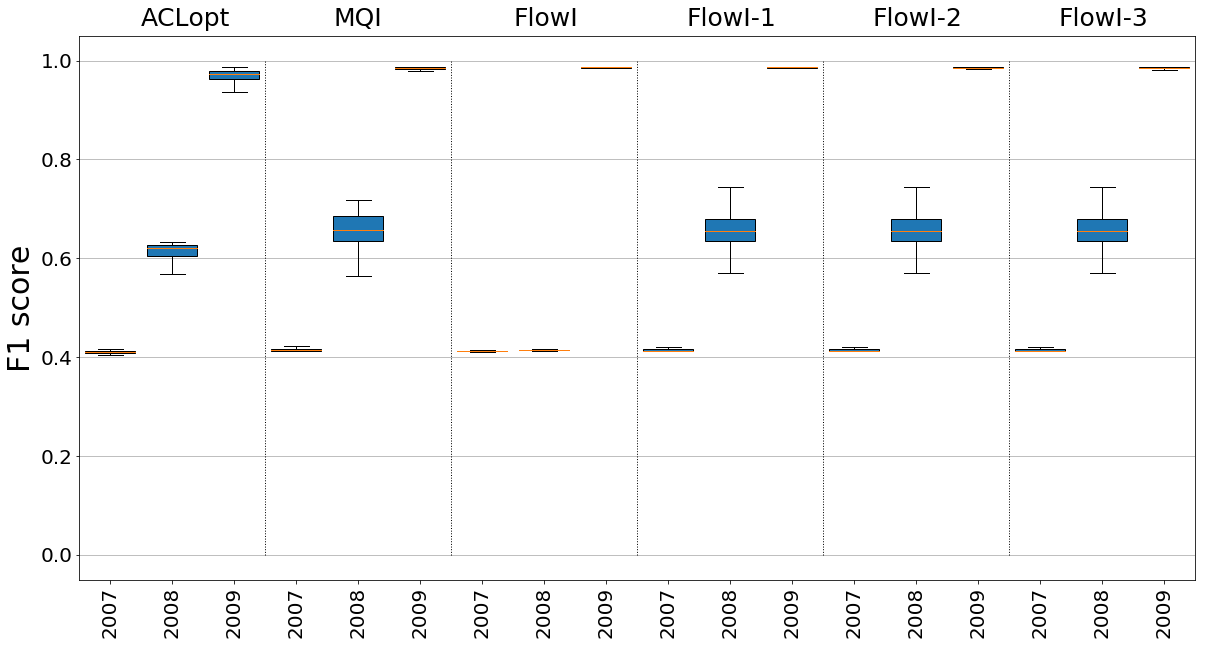

In [17]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_cond_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Brandeis_f1.png')

plt.show()

## Generate scatter plot for precision

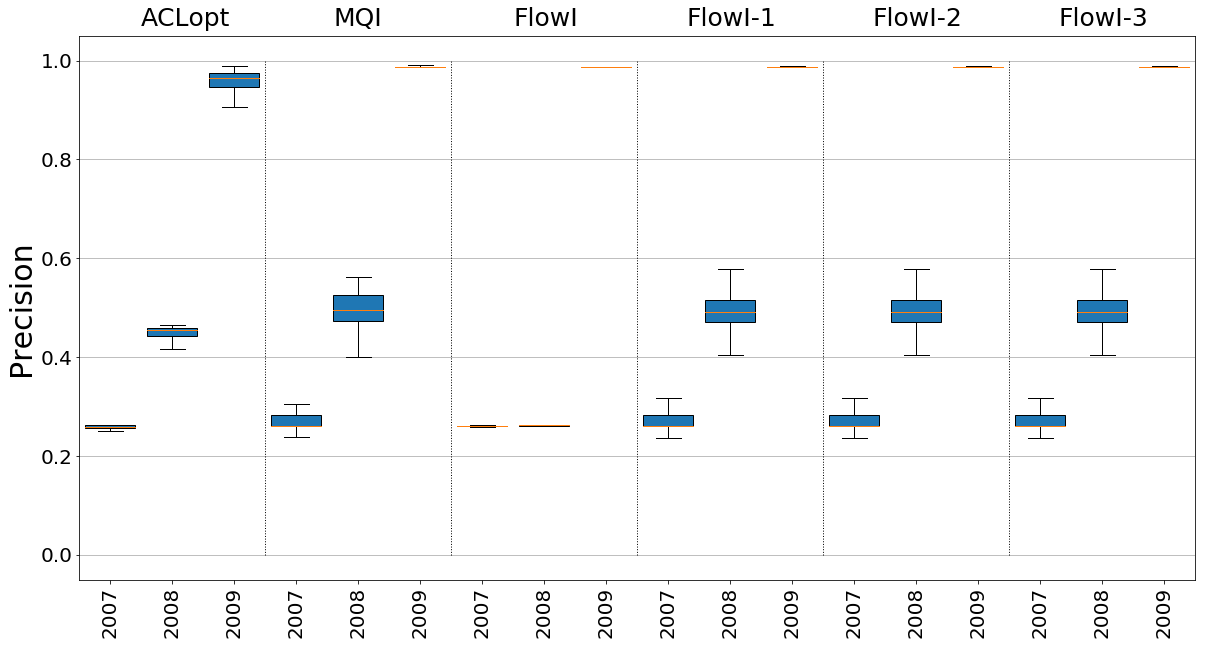

In [18]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Brandeis_precision.png')

plt.show()

## Generate scatter plot for recall

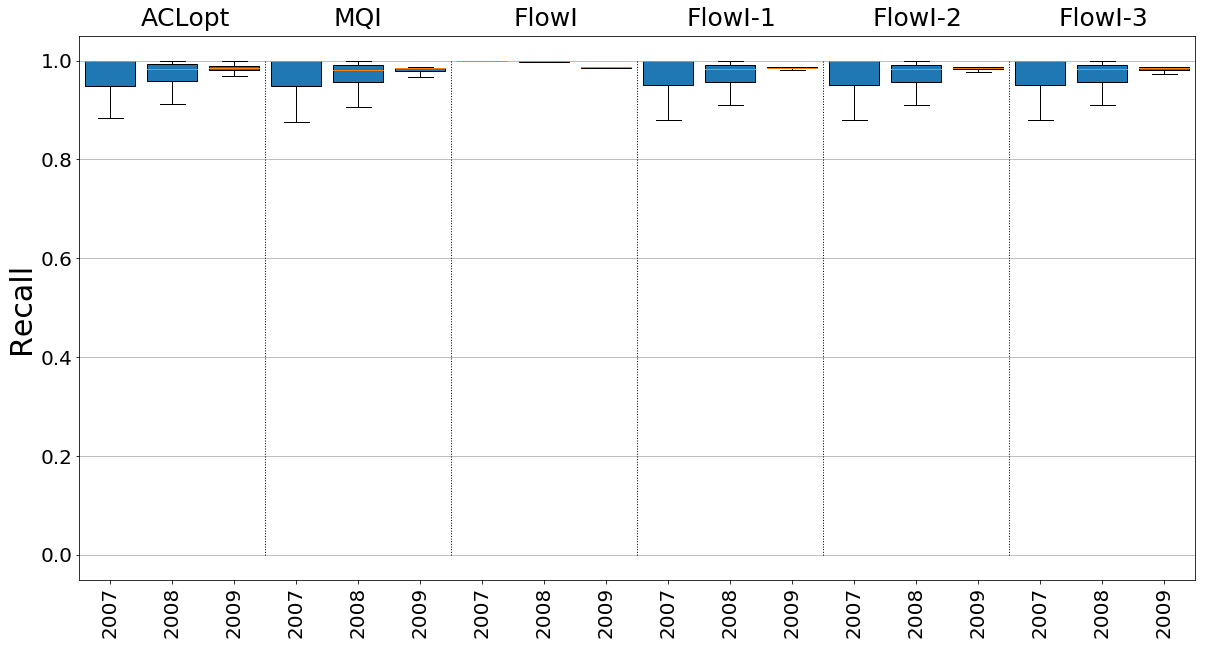

In [19]:
all_data = []
xlabels_ = []

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_cond_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Brandeis_recall.png')

plt.show()

In [20]:
all_data = []
xlabels_ = []

print('Results for ACLopt')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
        temp_rec.append(recall_best_cond_acl[i,j])
        temp_f1.append(f1score_best_cond_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for MQI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-1')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-2')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-3')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))

Results for ACLopt
Feature: 2007 Precision 0.25773876747940516 Recall 0.9997463256861098 F1 0.4097579990850007
Feature: 2008 Precision 0.4548786340697218 Recall 0.9836775692133843 F1 0.6216292734777404
Feature: 2009 Precision 0.9642682973604617 Recall 0.9858609454724289 F1 0.9729385111145297
Results for MQI
Feature: 2007 Precision 0.26108986143394974 Recall 0.9997463256861098 F1 0.4138885618188273
Feature: 2008 Precision 0.4952571221821957 Recall 0.9816529600100445 F1 0.6580258187704953
Feature: 2009 Precision 0.9870320139365765 Recall 0.9842318804942521 F1 0.9856379785416314
Results for FlowI
Feature: 2007 Precision 0.26009778666978667 Recall 0.999889017487673 F1 0.4127951306544718
Feature: 2008 Precision 0.2618516200233903 Recall 0.9988385962709524 F1 0.41490862069527096
Feature: 2009 Precision 0.9863277327554392 Recall 0.9861990532980881 F1 0.986338419928388
Results for FlowI-1
Feature: 2007 Precision 0.2606465850342385 Recall 0.9997463256861098 F1 0.4134145228789554
Feature: 2008 P